# DIFrauD Multilingual Data Quality Assessment
## Analyzing Language Diversity Impact on Classification Performance

**Course:** COSC 4371 Security Analytics - Fall 2025  
**Team Members:** Joseph Mascardo, Niket Gupta  

---

### Project Objective
Investigate whether all samples in the DIFrauD dataset are in English, analyze language distribution by class and domain, and study the impact on classification performance.

### Research Questions
1. What is the language distribution across classes and domains in DIFrauD?
2. How does removing non-English samples affect classifier performance?
3. Do transformer-based models handle multilingual content better than traditional ML?

---

## External Sources and References

### Dataset
- **DIFrauD Dataset**: https://huggingface.co/datasets/difraud/difraud
- **Citation**: Boumber, D., et al. (2024). "Domain-Agnostic Adapter Architecture for Deception Detection." LREC-COLING 2024.

### Libraries Used
- **langdetect**: https://pypi.org/project/langdetect/ - Language detection (port of Google's language-detection)
- **datasets**: https://huggingface.co/docs/datasets/ - HuggingFace datasets library
- **transformers**: https://huggingface.co/docs/transformers/ - HuggingFace transformers for DistilBERT
- **scikit-learn**: https://scikit-learn.org/ - Traditional ML classifiers
- **pandas/numpy**: Data processing
- **matplotlib/seaborn**: Visualizations

### Key References
- Conneau, A., et al. (2020). "Unsupervised cross-lingual representation learning at scale." ACL 2020.
- Devlin, J., et al. (2019). "BERT: Pre-training of deep bidirectional transformers." NAACL 2019.
- Verma, R. M., et al. (2019). "Data quality for security challenges." ACM CCS 2019.

---
## 1. Environment Setup and Imports

**Steps taken:**
1. Install required packages
2. Import necessary libraries
3. Set random seeds for reproducibility

In [17]:
# Install required packages (run once)
# Source: Standard pip installation
!pip install -q datasets langdetect transformers torch scikit-learn pandas numpy matplotlib seaborn tqdm

In [18]:

# Import libraries
import os
import warnings
from getpass import getpass
warnings.filterwarnings('ignore')

# Data handling
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

# Dataset loading - Source: https://huggingface.co/docs/datasets/
from datasets import load_dataset, concatenate_datasets

# Language detection - Source: https://pypi.org/project/langdetect/
from langdetect import detect, detect_langs, LangDetectException

# ML libraries - Source: https://scikit-learn.org/
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, accuracy_score,
    balanced_accuracy_score
)
from sklearn.preprocessing import LabelEncoder

# Deep Learning - Source: https://huggingface.co/docs/transformers/
import torch
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)

# Experiment tracking
import wandb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress tracking
from tqdm import tqdm

# Statistical testing
from scipy import stats

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Matplotlib style for cleaner figures
plt.style.use('seaborn-v0_8-whitegrid')

# -----------------------------------------------------------------------------
# Weights & Biases setup (optional)
# Enable by setting environment variable ENABLE_WANDB=true before running
# -----------------------------------------------------------------------------
WANDB_ENABLED = os.getenv("ENABLE_WANDB", "false").lower() == "true"
WANDB_PROJECT = os.getenv("WANDB_PROJECT", "difraud-language-analysis")
WANDB_ENTITY = os.getenv("WANDB_ENTITY")
wandb_run = None


def prompt_wandb_login():
    """Prompt the user for a W&B API key when logging is enabled.

    This keeps the workflow interactive without forcing authentication when
    ENABLE_WANDB is false. If the WANDB_API_KEY environment variable is set,
    the login uses that value automatically.
    """

    if not WANDB_ENABLED:
        print("Weights & Biases logging is disabled. Set ENABLE_WANDB=true to enable.")
        return None

    print("Weights & Biases logging is enabled.- Set WANDB_API_KEY env var, or paste it when prompted.")

    api_key = os.getenv("WANDB_API_KEY")
    if api_key:
        wandb.login(key=api_key)
    else:
        api_key = getpass("Enter your W&B API key (input hidden): ")
        wandb.login(key=api_key)

    run = wandb.init(project=WANDB_PROJECT, entity=WANDB_ENTITY, reinit=True)
    print(f"Initialized W&B run: {run.name}")
    return run


def log_figure(fig, name):
    """Log a matplotlib figure to Weights & Biases when enabled."""
    if wandb_run is not None:
        wandb_run.log({name: wandb.Image(fig)})


print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")



All libraries imported successfully!
PyTorch version: 2.9.0+cu126
CUDA available: True


In [19]:
# Additional NLP + timing utilities
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from time import perf_counter


---
## 2. Load DIFrauD Dataset

**Steps taken:**
1. Load all 7 domains from HuggingFace
2. Combine train, validation, and test splits
3. Create unified DataFrame with domain labels

**Dataset Source:** https://huggingface.co/datasets/difraud/difraud

In [20]:
# Define all domains in DIFrauD dataset
DOMAINS = [
    'fake_news',
    'job_scams',
    'phishing',
    'political_statements',
    'product_reviews',
    'sms',
    'twitter_rumours'
]

def load_difraud_dataset():
    """
    Load all domains from DIFrauD dataset by directly reading JSONL files.
    Source: HuggingFace datasets library
    Dataset: https://huggingface.co/datasets/difraud/difraud

    Note: The dataset uses legacy loading scripts no longer supported by datasets library,
    so we load directly from the JSONL files using data_files parameter.
    """
    all_data = []

    for domain in tqdm(DOMAINS, desc="Loading domains"):
        try:
            # Load directly from JSONL files using data_files parameter
            # This bypasses the deprecated loading script
            base_url = f"https://huggingface.co/datasets/difraud/difraud/resolve/main/{domain}"

            dataset = load_dataset(
                'json',
                data_files={
                    'train': f"{base_url}/train.jsonl",
                    'validation': f"{base_url}/validation.jsonl",
                    'test': f"{base_url}/test.jsonl"
                }
            )

            # Combine all splits
            for split in ['train', 'validation', 'test']:
                if split in dataset:
                    df_split = dataset[split].to_pandas()
                    df_split['domain'] = domain
                    df_split['split'] = split
                    all_data.append(df_split)

        except Exception as e:
            print(f"Error loading {domain}: {e}")

    # Combine all data
    if len(all_data) == 0:
        raise ValueError("No data was loaded. Check dataset availability and internet connection.")

    df = pd.concat(all_data, ignore_index=True)
    return df

# Load the dataset
print("Loading DIFrauD dataset from HuggingFace...")
print("(Downloading JSONL files directly - this may take a few minutes)\n")
df = load_difraud_dataset()

print(f"\nDataset loaded successfully!")
print(f"Total samples: {len(df):,}")
print(f"Columns: {df.columns.tolist()}")

Loading DIFrauD dataset from HuggingFace...
(Downloading JSONL files directly - this may take a few minutes)



Loading domains: 100%|██████████| 7/7 [00:00<00:00,  9.16it/s]


Dataset loaded successfully!
Total samples: 95,854
Columns: ['text', 'label', 'domain', 'split']


In [21]:
# Dataset overview
print("="*60)
print("DATASET OVERVIEW")
print("="*60)

print("\n--- Samples by Domain ---")
domain_counts = df.groupby('domain').agg({
    'text': 'count',
    'label': ['sum', 'mean']
}).round(3)
domain_counts.columns = ['Total', 'Deceptive', 'Deceptive_Ratio']
domain_counts['Non-Deceptive'] = domain_counts['Total'] - domain_counts['Deceptive']
print(domain_counts)

print("\n--- Overall Class Distribution ---")
print(f"Deceptive (label=1): {df['label'].sum():,} ({df['label'].mean()*100:.2f}%)")
print(f"Non-Deceptive (label=0): {(df['label']==0).sum():,} ({(1-df['label'].mean())*100:.2f}%)")

print("\n--- Sample Text Lengths ---")
df['text_length'] = df['text'].str.len()
print(df.groupby('domain')['text_length'].describe().round(1))

DATASET OVERVIEW

--- Samples by Domain ---
                      Total  Deceptive  Deceptive_Ratio  Non-Deceptive
domain                                                                
fake_news             20456       8832            0.432          11624
job_scams             14295        599            0.042          13696
phishing              15272       6074            0.398           9198
political_statements  12497       8042            0.644           4455
product_reviews       20971      10492            0.500          10479
sms                    6574       1274            0.194           5300
twitter_rumours        5789       1969            0.340           3820

--- Overall Class Distribution ---
Deceptive (label=1): 37,282 (38.89%)
Non-Deceptive (label=0): 58,572 (61.11%)

--- Sample Text Lengths ---
                        count    mean     std   min     25%     50%     75%  \
domain                                                                        
fake_news       

---
## 2.5 Synthetic Multilingual Dataset Generation (Optimized)

**Objective:** Create a synthetic multilingual dataset by translating English samples to multiple languages.

**Optimizations Applied:**
1. **Model:** Meta's NLLB-200 (facebook/nllb-200-distilled-600M) - faster and supports 200 languages
2. **Dataset Size:** Reduced to 20k samples with stratified sampling (maintains domain/class balance)
3. **Batch Processing:** batch_size=32 for GPU efficiency
4. **GPU Acceleration:** Automatic CUDA detection and usage
5. **Checkpointing:** Saves progress after each language for resume capability

**Target Distribution (Simplified):**
- 40% English (original samples)
- 30% Spanish (translated)
- 20% French (translated)
- 10% Arabic (translated)

**Expected Time:** 10-15 minutes (GPU) / 30-40 minutes (CPU)

**Source:** Meta NLLB-200 - https://huggingface.co/facebook/nllb-200-distilled-600M

In [22]:
# Install translation dependencies (run once)
# Source: Meta NLLB-200 model
!pip install -q sentencepiece

In [23]:
# Translation Configuration and Model Loading
# Source: Meta NLLB-200 - https://huggingface.co/facebook/nllb-200-distilled-600M

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import gc
import os
from datetime import datetime

# =============================================================================
# CONFIGURATION
# =============================================================================

# Target dataset size (reduced for speed)
TARGET_DATASET_SIZE = 20000

# NLLB-200 language codes (different from ISO codes)
# Reference: https://github.com/facebookresearch/flores/blob/main/flores200/README.md
TRANSLATION_CONFIG = {
    'spa_Latn': {'proportion': 0.30, 'name': 'Spanish', 'code': 'es'},
    'fra_Latn': {'proportion': 0.20, 'name': 'French', 'code': 'fr'},
    'arb_Arab': {'proportion': 0.10, 'name': 'Arabic', 'code': 'ar'},
}

ENGLISH_PROPORTION = 0.40  # Keep 40% English in synthetic dataset

# NLLB model configuration
NLLB_MODEL_NAME = "facebook/nllb-200-distilled-600M"

# Batch size for translation (larger = faster on GPU)
TRANSLATION_BATCH_SIZE = 32

# Checkpoint directory
CHECKPOINT_DIR = "./translation_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Device selection
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("=" * 60)
print("TRANSLATION CONFIGURATION")
print("=" * 60)
print(f"Model: {NLLB_MODEL_NAME}")
print(f"Device: {DEVICE}")
print(f"Target dataset size: {TARGET_DATASET_SIZE:,}")
print(f"Batch size: {TRANSLATION_BATCH_SIZE}")
print(f"Checkpoint directory: {CHECKPOINT_DIR}")
print()
print("Language Distribution:")
print(f"  English (original): {ENGLISH_PROPORTION*100:.0f}%")
for lang, cfg in TRANSLATION_CONFIG.items():
    print(f"  {cfg['name']} ({cfg['code']}): {cfg['proportion']*100:.0f}%")

total_translated = sum(cfg['proportion'] for cfg in TRANSLATION_CONFIG.values())
print(f"\nTotal: {(ENGLISH_PROPORTION + total_translated)*100:.0f}%")

TRANSLATION CONFIGURATION
Model: facebook/nllb-200-distilled-600M
Device: cuda
Target dataset size: 20,000
Batch size: 32
Checkpoint directory: ./translation_checkpoints

Language Distribution:
  English (original): 40%
  Spanish (es): 30%
  French (fr): 20%
  Arabic (ar): 10%

Total: 100%


In [24]:
class OptimizedTranslator:
    """
    Fast translator using Meta's NLLB-200 model.
    Optimized for GPU batch processing with checkpoint support.

    Source: https://huggingface.co/facebook/nllb-200-distilled-600M
    """

    def __init__(self, model_name=NLLB_MODEL_NAME, device=DEVICE, batch_size=TRANSLATION_BATCH_SIZE):
        """Initialize translator with NLLB-200 model."""
        self.device = device
        self.batch_size = batch_size
        self.model_name = model_name
        self.model = None
        self.tokenizer = None
        self._load_model()

    def _load_model(self):
        """Load model and tokenizer once."""
        print(f"Loading NLLB-200 model: {self.model_name}")
        print(f"Device: {self.device}")

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(self.model_name)
        self.model.to(self.device)
        self.model.eval()

        print("Model loaded successfully!")
        if self.device == 'cuda':
            print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

    def translate_batch(self, texts, target_lang, max_length=256):
        """
        Translate a batch of texts to the target language.

        Parameters:
        - texts: List of strings to translate
        - target_lang: NLLB language code (e.g., 'spa_Latn')
        - max_length: Maximum sequence length

        Returns:
        - List of translated texts
        """
        self.tokenizer.src_lang = "eng_Latn"
        translations = []

        for i in range(0, len(texts), self.batch_size):
            batch = texts[i:i + self.batch_size]
            batch = [text[:2000] if len(text) > 2000 else text for text in batch]

            try:
                inputs = self.tokenizer(
                    batch,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=max_length
                ).to(self.device)

                with torch.no_grad():
                    translated = self.model.generate(
                        **inputs,
                        forced_bos_token_id=self.tokenizer.convert_tokens_to_ids(target_lang),
                        max_length=max_length,
                        num_beams=4,
                        early_stopping=True
                    )

                decoded = self.tokenizer.batch_decode(translated, skip_special_tokens=True)
                translations.extend(decoded)

            except Exception as e:
                print(f"Warning: Translation error at batch {i//self.batch_size}: {e}")
                translations.extend(batch)

        return translations

    def translate_with_progress(self, texts, target_lang, lang_name):
        """
        Translate texts with progress bar and time estimation.
        """
        from time import time

        translations = []
        total_batches = (len(texts) + self.batch_size - 1) // self.batch_size
        start_time = time()

        pbar = tqdm(
            range(0, len(texts), self.batch_size),
            desc=f"Translating to {lang_name}",
            total=total_batches,
            unit="batch"
        )

        for i in pbar:
            batch = texts[i:i + self.batch_size]
            batch_translations = self.translate_batch(batch, target_lang)
            translations.extend(batch_translations)

            elapsed = time() - start_time
            completed_batches = (i // self.batch_size) + 1
            if completed_batches > 0:
                avg_time_per_batch = elapsed / completed_batches
                remaining_batches = total_batches - completed_batches
                eta = avg_time_per_batch * remaining_batches
                pbar.set_postfix({
                    'ETA': f'{eta/60:.1f}min',
                    'Speed': f'{completed_batches * self.batch_size / elapsed:.1f} samples/s'
                })

        return translations

    def clear_memory(self):
        """Clear GPU memory."""
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Initialize translator
print("\nInitializing optimized translator...")
translator = OptimizedTranslator()
print("\nTranslator ready!")


Initializing optimized translator...
Loading NLLB-200 model: facebook/nllb-200-distilled-600M
Device: cuda
Model loaded successfully!
GPU Memory: 42.5 GB

Translator ready!


In [25]:
def create_stratified_sample(df, n_samples, random_state=SEED):
    """
    Create a stratified sample maintaining domain and label balance.
    """
    df_temp = df.copy()
    df_temp['stratify_key'] = df_temp['domain'] + '_' + df_temp['label'].astype(str)

    proportions = df_temp['stratify_key'].value_counts(normalize=True)
    samples_per_group = (proportions * n_samples).round().astype(int)

    diff = n_samples - samples_per_group.sum()
    if diff != 0:
        adjustment = 1 if diff > 0 else -1
        for key in samples_per_group.nlargest(abs(diff)).index:
            samples_per_group[key] += adjustment

    sampled_dfs = []
    for key, count in samples_per_group.items():
        group = df_temp[df_temp['stratify_key'] == key]
        n = min(count, len(group))
        if n > 0:
            sampled_dfs.append(group.sample(n=n, random_state=random_state))

    result = pd.concat(sampled_dfs, ignore_index=True)
    result = result.drop(columns=['stratify_key'])
    return result

# Create reduced dataset
print(f"\nCreating stratified sample of {TARGET_DATASET_SIZE:,} from {len(df):,} samples...")
df_reduced = create_stratified_sample(df, TARGET_DATASET_SIZE)

print(f"\nReduced dataset created:")
print(f"  Total samples: {len(df_reduced):,}")
print(f"  Domain distribution:")
for domain in DOMAINS:
    orig_pct = (df['domain'] == domain).mean() * 100
    reduced_pct = (df_reduced['domain'] == domain).mean() * 100
    print(f"    {domain}: {reduced_pct:.1f}% (original: {orig_pct:.1f}%)")
print(f"  Class balance: {df_reduced['label'].mean()*100:.1f}% deceptive")


Creating stratified sample of 20,000 from 95,854 samples...

Reduced dataset created:
  Total samples: 20,000
  Domain distribution:
    fake_news: 21.3% (original: 21.3%)
    job_scams: 14.9% (original: 14.9%)
    phishing: 15.9% (original: 15.9%)
    political_statements: 13.0% (original: 13.0%)
    product_reviews: 21.9% (original: 21.9%)
    sms: 6.9% (original: 6.9%)
    twitter_rumours: 6.0% (original: 6.0%)
  Class balance: 38.9% deceptive


In [26]:
def generate_synthetic_dataset_optimized(df_source, checkpoint_dir=CHECKPOINT_DIR, resume=True):
    """
    Generate synthetic multilingual dataset with checkpointing support.
    """
    from time import time
    import json as json_lib

    target_size = len(df_source)

    print(f"\n{'='*70}")
    print("GENERATING SYNTHETIC MULTILINGUAL DATASET (OPTIMIZED)")
    print(f"{'='*70}")
    print(f"Source samples: {target_size:,}")

    # Calculate samples per language
    n_english = int(target_size * ENGLISH_PROPORTION)
    samples_by_lang = {
        lang: int(target_size * cfg['proportion'])
        for lang, cfg in TRANSLATION_CONFIG.items()
    }

    total_allocated = n_english + sum(samples_by_lang.values())
    if total_allocated < target_size:
        n_english += (target_size - total_allocated)

    print(f"\nSamples per language:")
    print(f"  English (original): {n_english:,}")
    for lang, cfg in TRANSLATION_CONFIG.items():
        print(f"  {cfg['name']}: {samples_by_lang[lang]:,}")

    # Check for checkpoints
    checkpoint_file = os.path.join(checkpoint_dir, "translation_progress.json")
    completed_langs = []
    synthetic_data = []

    if resume and os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'r') as f:
            checkpoint = json_lib.load(f)
        completed_langs = checkpoint.get('completed_languages', [])
        print(f"\nResuming from checkpoint. Completed: {completed_langs}")

        for lang in completed_langs:
            lang_file = os.path.join(checkpoint_dir, f"translated_{lang}.csv")
            if os.path.exists(lang_file):
                synthetic_data.append(pd.read_csv(lang_file))
                print(f"  Loaded {lang}: {len(synthetic_data[-1]):,} samples")

    start_time = time()

    # 1. English samples
    if 'english' not in completed_langs:
        print(f"\n[Step 1] Sampling {n_english:,} English texts...")
        english_sample = create_stratified_sample(df_source, n_english, SEED)
        english_sample = english_sample.copy()
        english_sample['data_source'] = 'original'
        english_sample['is_translated'] = False
        english_sample['source_language'] = 'en'
        english_sample['target_language'] = 'en'

        english_file = os.path.join(checkpoint_dir, "translated_english.csv")
        english_sample.to_csv(english_file, index=False)
        completed_langs.append('english')
        synthetic_data.append(english_sample)

        with open(checkpoint_file, 'w') as f:
            json_lib.dump({'completed_languages': completed_langs}, f)
        print(f"  English samples saved: {len(english_sample):,}")

    # 2. Translate each language
    step = 2
    for lang, cfg in TRANSLATION_CONFIG.items():
        if lang in completed_langs:
            print(f"\n[Step {step}] Skipping {cfg['name']} (already completed)")
            step += 1
            continue

        n_samples = samples_by_lang[lang]
        print(f"\n[Step {step}] Translating {n_samples:,} samples to {cfg['name']}...")
        step += 1

        lang_sample = create_stratified_sample(df_source, n_samples, SEED + hash(lang) % 1000)
        lang_sample = lang_sample.copy()

        texts = lang_sample['text'].tolist()
        translated = translator.translate_with_progress(texts, lang, cfg['name'])

        lang_sample['text'] = translated
        lang_sample['data_source'] = 'synthetic'
        lang_sample['is_translated'] = True
        lang_sample['source_language'] = 'en'
        lang_sample['target_language'] = cfg['code']

        lang_file = os.path.join(checkpoint_dir, f"translated_{lang}.csv")
        lang_sample.to_csv(lang_file, index=False)
        completed_langs.append(lang)
        synthetic_data.append(lang_sample)

        with open(checkpoint_file, 'w') as f:
            json_lib.dump({'completed_languages': completed_langs}, f)

        print(f"  {cfg['name']} saved: {len(lang_sample):,} samples")
        translator.clear_memory()

    # Combine all data
    df_synthetic = pd.concat(synthetic_data, ignore_index=True)
    df_synthetic = df_synthetic.sample(frac=1, random_state=SEED).reset_index(drop=True)

    total_time = time() - start_time

    print(f"\n{'='*70}")
    print("GENERATION COMPLETE!")
    print(f"{'='*70}")
    print(f"Total samples: {len(df_synthetic):,}")
    print(f"Total time: {total_time/60:.1f} minutes")

    return df_synthetic

print("Optimized generation function defined.")

Optimized generation function defined.


In [27]:
# Generate the synthetic multilingual dataset
# Optimized for 10-15 minute completion on GPU

print("=" * 70)
print("STARTING OPTIMIZED SYNTHETIC DATASET GENERATION")
print("=" * 70)
print(f"\nDevice: {DEVICE}")
print(f"Target size: {TARGET_DATASET_SIZE:,} samples")
print(f"Batch size: {TRANSLATION_BATCH_SIZE}")

if DEVICE == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\nNote: Progress is saved after each language. Re-run to resume if interrupted.")
print("To restart fresh, delete:", CHECKPOINT_DIR)

# Generate synthetic dataset
df_synthetic = generate_synthetic_dataset_optimized(df_reduced, resume=True)

print(f"\nSynthetic dataset created with {len(df_synthetic):,} samples")
print("\nLanguage distribution:")
print(df_synthetic['target_language'].value_counts())

STARTING OPTIMIZED SYNTHETIC DATASET GENERATION

Device: cuda
Target size: 20,000 samples
Batch size: 32
GPU: NVIDIA A100-SXM4-40GB

Note: Progress is saved after each language. Re-run to resume if interrupted.
To restart fresh, delete: ./translation_checkpoints

GENERATING SYNTHETIC MULTILINGUAL DATASET (OPTIMIZED)
Source samples: 20,000

Samples per language:
  English (original): 8,000
  Spanish: 6,000
  French: 4,000
  Arabic: 2,000

Resuming from checkpoint. Completed: ['english', 'spa_Latn', 'fra_Latn', 'arb_Arab']
  Loaded english: 8,000 samples
  Loaded spa_Latn: 6,000 samples
  Loaded fra_Latn: 4,000 samples
  Loaded arb_Arab: 2,000 samples

[Step 2] Skipping Spanish (already completed)

[Step 3] Skipping French (already completed)

[Step 4] Skipping Arabic (already completed)

GENERATION COMPLETE!
Total samples: 20,000
Total time: 0.0 minutes

Synthetic dataset created with 20,000 samples

Language distribution:
target_language
en    8000
es    6000
fr    4000
ar    2000
Name

In [28]:
# Add metadata columns to original REDUCED dataset
df_original = df_reduced.copy()
df_original['data_source'] = 'original'
df_original['is_translated'] = False
df_original['source_language'] = 'en'
df_original['target_language'] = 'en'

print("Original (reduced) dataset metadata added:")
print(f"  Samples: {len(df_original):,}")
print(f"  Columns: {df_original.columns.tolist()}")

Original (reduced) dataset metadata added:
  Samples: 20,000
  Columns: ['text', 'label', 'domain', 'split', 'text_length', 'data_source', 'is_translated', 'source_language', 'target_language']


In [29]:
# Save datasets as separate files

# 1. Save original (mostly English) dataset
original_path = 'difraud_original.csv'
df_original.to_csv(original_path, index=False)
print(f"Original dataset saved: {original_path}")
print(f"  Size: {len(df_original):,} samples")

# 2. Save synthetic multilingual dataset
synthetic_path = 'difraud_synthetic_multilingual.csv'
df_synthetic.to_csv(synthetic_path, index=False)
print(f"\nSynthetic multilingual dataset saved: {synthetic_path}")
print(f"  Size: {len(df_synthetic):,} samples")

# 3. Create and save combined dataset with version flags
df_combined = pd.concat([
    df_original.assign(dataset_version='original'),
    df_synthetic.assign(dataset_version='synthetic')
], ignore_index=True)

combined_path = 'difraud_combined.csv'
df_combined.to_csv(combined_path, index=False)
print(f"\nCombined dataset saved: {combined_path}")
print(f"  Size: {len(df_combined):,} samples")

print("\n" + "="*60)
print("ALL DATASETS SAVED SUCCESSFULLY")
print("="*60)


Original dataset saved: difraud_original.csv
  Size: 20,000 samples

Synthetic multilingual dataset saved: difraud_synthetic_multilingual.csv
  Size: 20,000 samples

Combined dataset saved: difraud_combined.csv
  Size: 40,000 samples

ALL DATASETS SAVED SUCCESSFULLY


### 2.5.1 Dataset Validation

Validate the generated synthetic dataset to ensure:
1. Language distribution matches target percentages
2. Domain and class balance is maintained
3. Translation quality is acceptable

In [30]:
def validate_synthetic_dataset(df_synthetic, expected_english_ratio=0.40, tolerance=0.05):
    """
    Comprehensive validation of the synthetic multilingual dataset.
    """
    print("\n" + "="*70)
    print("SYNTHETIC DATASET VALIDATION")
    print("="*70)

    validation_results = {
        'language_distribution': {},
        'domain_balance': {},
        'class_balance': {},
        'translation_quality_samples': [],
        'passed': True,
        'warnings': []
    }

    # Expected proportions (updated for 3 languages)
    expected_proportions = {'en': 0.40, 'es': 0.30, 'fr': 0.20, 'ar': 0.10}

    # 1. Validate Language Distribution
    print("\n--- Language Distribution ---")
    lang_counts = df_synthetic['target_language'].value_counts()
    total_samples = len(df_synthetic)

    print(f"Total samples: {total_samples:,}\n")
    for lang, expected in expected_proportions.items():
        count = lang_counts.get(lang, 0)
        actual = count / total_samples
        diff = abs(actual - expected)
        status = "OK" if diff <= tolerance else "DEVIATION"
        print(f"  {lang}: {count:,} ({actual*100:.1f}%) - expected {expected*100:.0f}% [{status}]")

        if diff > tolerance:
            validation_results['warnings'].append(f"Language '{lang}' ratio deviates")

    # 2. Domain Balance
    print("\n--- Domain Balance ---")
    domain_counts = df_synthetic['domain'].value_counts(normalize=True) * 100
    for domain in sorted(df_synthetic['domain'].unique()):
        print(f"  {domain}: {domain_counts.get(domain, 0):.1f}%")

    # 3. Class Balance
    print("\n--- Class Balance ---")
    print(f"Deceptive ratio: {df_synthetic['label'].mean()*100:.1f}%")

    # 4. Translation Quality Samples
    print("\n--- Translation Quality Samples ---")
    for lang, name in [('es', 'Spanish'), ('fr', 'French'), ('ar', 'Arabic')]:
        lang_data = df_synthetic[df_synthetic['target_language'] == lang]
        if len(lang_data) > 0:
            sample = lang_data.sample(n=1, random_state=SEED).iloc[0]
            print(f"\n{name}:")
            print(f"  Domain: {sample['domain']}")
            print(f"  Text: {sample['text'][:150]}...")

    # Summary
    print("\n" + "="*70)
    if validation_results['warnings']:
        print("Warnings found:")
        for w in validation_results['warnings']:
            print(f"  ! {w}")
    else:
        print("All checks passed!")

    return validation_results

# Run validation
validation_results = validate_synthetic_dataset(df_synthetic)


SYNTHETIC DATASET VALIDATION

--- Language Distribution ---
Total samples: 20,000

  en: 8,000 (40.0%) - expected 40% [OK]
  es: 6,000 (30.0%) - expected 30% [OK]
  fr: 4,000 (20.0%) - expected 20% [OK]
  ar: 2,000 (10.0%) - expected 10% [OK]

--- Domain Balance ---
  fake_news: 21.3%
  job_scams: 14.9%
  phishing: 15.9%
  political_statements: 13.0%
  product_reviews: 21.9%
  sms: 6.9%
  twitter_rumours: 6.0%

--- Class Balance ---
Deceptive ratio: 38.9%

--- Translation Quality Samples ---

Spanish:
  Domain: product_reviews
  Text: El cinturón de cabeza en realidad no es tan ancho como en la imagen y no es realmente el mismo color vino como una especie de oro brillante y su incóm...

French:
  Domain: job_scams
  Text: Emploi - Ingénieur de conception physique (contrat) - Société de développement de produits de haut niveau - Raleigh, NC Location recherche d'ingénieur...

Arabic:
  Domain: job_scams
  Text: كويست كلية تبحث عن فرد للانضمام إلى الموظفين كمستشار القبول الواجبات والمسؤو

### 2.5.2 Dataset Comparator

Class to run experiments on both datasets and compare performance across models.

In [31]:
class DatasetComparator:
    """
    Runs comparative experiments on original vs synthetic multilingual datasets.
    Tests RF, LinearSVC, and DistilBERT models on both datasets.
    Provides statistical comparison and visualizations.
    """

    def __init__(self, df_original, df_synthetic, test_size=0.2, random_state=SEED):
        """
        Initialize comparator with both datasets.

        Parameters:
        - df_original: Original (mostly English) dataset
        - df_synthetic: Synthetic multilingual dataset
        - test_size: Proportion of data for testing
        - random_state: Random seed for reproducibility
        """
        self.df_original = df_original
        self.df_synthetic = df_synthetic
        self.test_size = test_size
        self.random_state = random_state
        self.results = {'original': {}, 'synthetic': {}}
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        print(f"DatasetComparator initialized")
        print(f"  Original dataset: {len(df_original):,} samples")
        print(f"  Synthetic dataset: {len(df_synthetic):,} samples")
        print(f"  Test size: {test_size*100:.0f}%")
        print(f"  Device: {self.device}")

    def prepare_splits(self, df, dataset_name):
        """Prepare train/test splits with stratification."""
        X = df['text'].values
        y = df['label'].values

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=self.test_size,
            stratify=y,
            random_state=self.random_state
        )

        print(f"\n{dataset_name} splits:")
        print(f"  Train: {len(X_train):,}, Test: {len(X_test):,}")
        print(f"  Train class balance: {y_train.mean():.2%} deceptive")
        print(f"  Test class balance: {y_test.mean():.2%} deceptive")

        return X_train, X_test, y_train, y_test

    def train_tfidf_model(self, X_train, y_train, X_test, y_test, model_type='rf'):
        """Train TF-IDF based model (RF or LinearSVC)."""
        # Vectorize
        vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)

        # Select model
        if model_type == 'rf':
            model = RandomForestClassifier(n_estimators=100, random_state=self.random_state, n_jobs=-1)
        else:
            model = LinearSVC(random_state=self.random_state, max_iter=5000)

        # Train
        start_time = perf_counter()
        model.fit(X_train_tfidf, y_train)
        train_time = perf_counter() - start_time

        # Predict
        y_pred = model.predict(X_test_tfidf)

        # Metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'precision_weighted': precision_score(y_test, y_pred, average='weighted'),
            'recall_weighted': recall_score(y_test, y_pred, average='weighted'),
            'train_time': train_time
        }

        return metrics, y_pred

    def train_distilbert(self, X_train, y_train, X_test, y_test, max_samples=10000):
        """Train DistilBERT classifier."""
        from datasets import Dataset

        # Subsample for faster training if needed
        if len(X_train) > max_samples:
            indices = np.random.RandomState(self.random_state).choice(
                len(X_train), max_samples, replace=False
            )
            X_train_sub = X_train[indices]
            y_train_sub = y_train[indices]
        else:
            X_train_sub = X_train
            y_train_sub = y_train

        # Create datasets
        train_dataset = Dataset.from_dict({'text': X_train_sub.tolist(), 'labels': y_train_sub.tolist()})
        test_dataset = Dataset.from_dict({'text': X_test.tolist(), 'labels': y_test.tolist()})

        # Tokenizer
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

        def tokenize(examples):
            return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

        train_dataset = train_dataset.map(tokenize, batched=True)
        test_dataset = test_dataset.map(tokenize, batched=True)

        # Model
        model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=2
        )

        # Training arguments
        training_args = TrainingArguments(
            output_dir='./comparator_results',
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            warmup_steps=100,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=50,
            eval_strategy='epoch',
            save_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='f1',
            report_to='none'
        )

        def compute_metrics(pred):
            labels = pred.label_ids
            preds = pred.predictions.argmax(-1)
            return {
                'accuracy': accuracy_score(labels, preds),
                'f1': f1_score(labels, preds, average='weighted')
            }

        # Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
        )

        # Train
        start_time = perf_counter()
        trainer.train()
        train_time = perf_counter() - start_time

        # Evaluate
        predictions = trainer.predict(test_dataset)
        y_pred = predictions.predictions.argmax(-1)

        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
            'f1_macro': f1_score(y_test, y_pred, average='macro'),
            'precision_weighted': precision_score(y_test, y_pred, average='weighted'),
            'recall_weighted': recall_score(y_test, y_pred, average='weighted'),
            'train_time': train_time
        }

        return metrics, y_pred

    def run_comparison(self, models=['rf', 'svc', 'distilbert']):
        """
        Run full comparison on both datasets.

        Parameters:
        - models: List of models to test ('rf', 'svc', 'distilbert')

        Returns:
        - DataFrame with comparison results
        """
        print("\n" + "="*70)
        print("RUNNING DATASET COMPARISON EXPERIMENTS")
        print("="*70)

        for dataset_name, df in [('original', self.df_original), ('synthetic', self.df_synthetic)]:
            print(f"\n{'='*50}")
            print(f"Processing: {dataset_name.upper()} dataset")
            print(f"{'='*50}")

            X_train, X_test, y_train, y_test = self.prepare_splits(df, dataset_name)

            if 'rf' in models:
                print("\nTraining Random Forest...")
                metrics, _ = self.train_tfidf_model(X_train, y_train, X_test, y_test, 'rf')
                self.results[dataset_name]['Random Forest'] = metrics
                print(f"  Accuracy: {metrics['accuracy']:.4f}")
                print(f"  F1 (weighted): {metrics['f1_weighted']:.4f}")

            if 'svc' in models:
                print("\nTraining LinearSVC...")
                metrics, _ = self.train_tfidf_model(X_train, y_train, X_test, y_test, 'svc')
                self.results[dataset_name]['LinearSVC'] = metrics
                print(f"  Accuracy: {metrics['accuracy']:.4f}")
                print(f"  F1 (weighted): {metrics['f1_weighted']:.4f}")

            if 'distilbert' in models:
                print("\nTraining DistilBERT...")
                metrics, _ = self.train_distilbert(X_train, y_train, X_test, y_test)
                self.results[dataset_name]['DistilBERT'] = metrics
                print(f"  Accuracy: {metrics['accuracy']:.4f}")
                print(f"  F1 (weighted): {metrics['f1_weighted']:.4f}")

        return self.get_comparison_df()

    def get_comparison_df(self):
        """Get comparison results as DataFrame."""
        rows = []
        for dataset_name in ['original', 'synthetic']:
            for model_name, metrics in self.results[dataset_name].items():
                row = {'dataset': dataset_name, 'model': model_name}
                row.update(metrics)
                rows.append(row)
        return pd.DataFrame(rows)

    def statistical_comparison(self):
        """Perform statistical comparison of results."""
        print("\n" + "="*70)
        print("STATISTICAL COMPARISON")
        print("="*70)

        for model in self.results['original'].keys():
            if model not in self.results['synthetic']:
                continue

            orig_metrics = self.results['original'][model]
            synth_metrics = self.results['synthetic'][model]

            print(f"\n{model}:")
            print("-" * 40)

            for metric in ['accuracy', 'f1_weighted', 'f1_macro']:
                orig_val = orig_metrics[metric]
                synth_val = synth_metrics[metric]
                diff = synth_val - orig_val
                pct_change = (diff / orig_val) * 100 if orig_val > 0 else 0

                direction = "+" if diff > 0 else ""
                print(f"  {metric}:")
                print(f"    Original:  {orig_val:.4f}")
                print(f"    Synthetic: {synth_val:.4f}")
                print(f"    Change:    {direction}{diff:.4f} ({direction}{pct_change:.2f}%)")

    def plot_comparison(self, figsize=(14, 10)):
        """Generate comparison visualizations."""
        comparison_df = self.get_comparison_df()

        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # 1. Accuracy comparison
        ax = axes[0, 0]
        models = comparison_df['model'].unique()
        x = np.arange(len(models))
        width = 0.35

        orig_acc = comparison_df[comparison_df['dataset'] == 'original']['accuracy'].values
        synth_acc = comparison_df[comparison_df['dataset'] == 'synthetic']['accuracy'].values

        ax.bar(x - width/2, orig_acc, width, label='Original', color='steelblue')
        ax.bar(x + width/2, synth_acc, width, label='Synthetic', color='coral')
        ax.set_ylabel('Accuracy')
        ax.set_title('Accuracy: Original vs Synthetic Dataset')
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.legend()
        ax.set_ylim(0.5, 1.0)

        # 2. F1 Score comparison
        ax = axes[0, 1]
        orig_f1 = comparison_df[comparison_df['dataset'] == 'original']['f1_weighted'].values
        synth_f1 = comparison_df[comparison_df['dataset'] == 'synthetic']['f1_weighted'].values

        ax.bar(x - width/2, orig_f1, width, label='Original', color='steelblue')
        ax.bar(x + width/2, synth_f1, width, label='Synthetic', color='coral')
        ax.set_ylabel('F1 Score (Weighted)')
        ax.set_title('F1 Score: Original vs Synthetic Dataset')
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.legend()
        ax.set_ylim(0.5, 1.0)

        # 3. Training time comparison
        ax = axes[1, 0]
        orig_time = comparison_df[comparison_df['dataset'] == 'original']['train_time'].values
        synth_time = comparison_df[comparison_df['dataset'] == 'synthetic']['train_time'].values

        ax.bar(x - width/2, orig_time, width, label='Original', color='steelblue')
        ax.bar(x + width/2, synth_time, width, label='Synthetic', color='coral')
        ax.set_ylabel('Training Time (seconds)')
        ax.set_title('Training Time: Original vs Synthetic Dataset')
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.legend()

        # 4. Performance difference (synthetic - original)
        ax = axes[1, 1]
        metrics_to_compare = ['accuracy', 'f1_weighted', 'balanced_accuracy']

        for i, model in enumerate(models):
            orig_row = comparison_df[(comparison_df['dataset'] == 'original') &
                                     (comparison_df['model'] == model)].iloc[0]
            synth_row = comparison_df[(comparison_df['dataset'] == 'synthetic') &
                                      (comparison_df['model'] == model)].iloc[0]

            diffs = [synth_row[m] - orig_row[m] for m in metrics_to_compare]
            ax.bar(np.arange(len(metrics_to_compare)) + i*0.25, diffs, 0.25, label=model)

        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax.set_ylabel('Performance Difference')
        ax.set_title('Performance Change (Synthetic - Original)')
        ax.set_xticks(np.arange(len(metrics_to_compare)) + 0.25)
        ax.set_xticklabels(['Accuracy', 'F1 Weighted', 'Balanced Acc'])
        ax.legend()

        plt.tight_layout()
        plt.savefig('dataset_comparison_results.png', dpi=150, bbox_inches='tight')
        log_figure(fig, 'dataset_comparison_results')
        plt.show()

        print("\nVisualization saved to: dataset_comparison_results.png")

print("DatasetComparator class defined.")


DatasetComparator class defined.


In [32]:
# Initialize and run comparison experiments
# Note: This will take significant time (~30-60 minutes)
# To save time, you can run with just RF and SVC first:
# comparator.run_comparison(models=['rf', 'svc'])

comparator = DatasetComparator(df_original, df_synthetic)

# Run comparison with all models
# Set models=['rf', 'svc'] to skip DistilBERT for faster execution
comparison_results = comparator.run_comparison(models=['rf', 'svc', 'distilbert'])

print("\n" + "="*70)
print("COMPARISON RESULTS SUMMARY")
print("="*70)
print(comparison_results.to_string(index=False))


DatasetComparator initialized
  Original dataset: 20,000 samples
  Synthetic dataset: 20,000 samples
  Test size: 20%
  Device: cuda

RUNNING DATASET COMPARISON EXPERIMENTS

Processing: ORIGINAL dataset

original splits:
  Train: 16,000, Test: 4,000
  Train class balance: 38.89% deceptive
  Test class balance: 38.90% deceptive

Training Random Forest...
  Accuracy: 0.7688
  F1 (weighted): 0.7597

Training LinearSVC...
  Accuracy: 0.7692
  F1 (weighted): 0.7679

Training DistilBERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.417600,0.367151,0.810250,0.811890
2,0.305400,0.357774,0.832000,0.832477
3,0.152600,0.528042,0.830750,0.830760


  Accuracy: 0.8320
  F1 (weighted): 0.8325

Processing: SYNTHETIC dataset

synthetic splits:
  Train: 16,000, Test: 4,000
  Train class balance: 38.89% deceptive
  Test class balance: 38.90% deceptive

Training Random Forest...
  Accuracy: 0.7320
  F1 (weighted): 0.7170

Training LinearSVC...
  Accuracy: 0.7315
  F1 (weighted): 0.7293

Training DistilBERT...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.494200,0.484284,0.749500,0.741707
2,0.384300,0.446435,0.773250,0.772937
3,0.243200,0.572134,0.768500,0.767112


  Accuracy: 0.7732
  F1 (weighted): 0.7729

COMPARISON RESULTS SUMMARY
  dataset         model  accuracy  balanced_accuracy  f1_weighted  f1_macro  precision_weighted  recall_weighted  train_time
 original Random Forest   0.76875           0.731952     0.759711  0.740824            0.770262          0.76875    7.254657
 original     LinearSVC   0.76925           0.751859     0.767850  0.754483            0.767310          0.76925    1.256823
 original    DistilBERT   0.83200           0.826327     0.832477  0.824326            0.833242          0.83200  179.650846
synthetic Random Forest   0.73200           0.686350     0.717033  0.692603            0.733298          0.73200    5.665507
synthetic     LinearSVC   0.73150           0.710576     0.729332  0.713293            0.728520          0.73150    0.497509
synthetic    DistilBERT   0.77325           0.760153     0.772937  0.760845            0.772676          0.77325  180.571820


In [33]:
# Statistical comparison of results
comparator.statistical_comparison()



STATISTICAL COMPARISON

Random Forest:
----------------------------------------
  accuracy:
    Original:  0.7688
    Synthetic: 0.7320
    Change:    -0.0368 (-4.78%)
  f1_weighted:
    Original:  0.7597
    Synthetic: 0.7170
    Change:    -0.0427 (-5.62%)
  f1_macro:
    Original:  0.7408
    Synthetic: 0.6926
    Change:    -0.0482 (-6.51%)

LinearSVC:
----------------------------------------
  accuracy:
    Original:  0.7692
    Synthetic: 0.7315
    Change:    -0.0377 (-4.91%)
  f1_weighted:
    Original:  0.7679
    Synthetic: 0.7293
    Change:    -0.0385 (-5.02%)
  f1_macro:
    Original:  0.7545
    Synthetic: 0.7133
    Change:    -0.0412 (-5.46%)

DistilBERT:
----------------------------------------
  accuracy:
    Original:  0.8320
    Synthetic: 0.7732
    Change:    -0.0587 (-7.06%)
  f1_weighted:
    Original:  0.8325
    Synthetic: 0.7729
    Change:    -0.0595 (-7.15%)
  f1_macro:
    Original:  0.8243
    Synthetic: 0.7608
    Change:    -0.0635 (-7.70%)


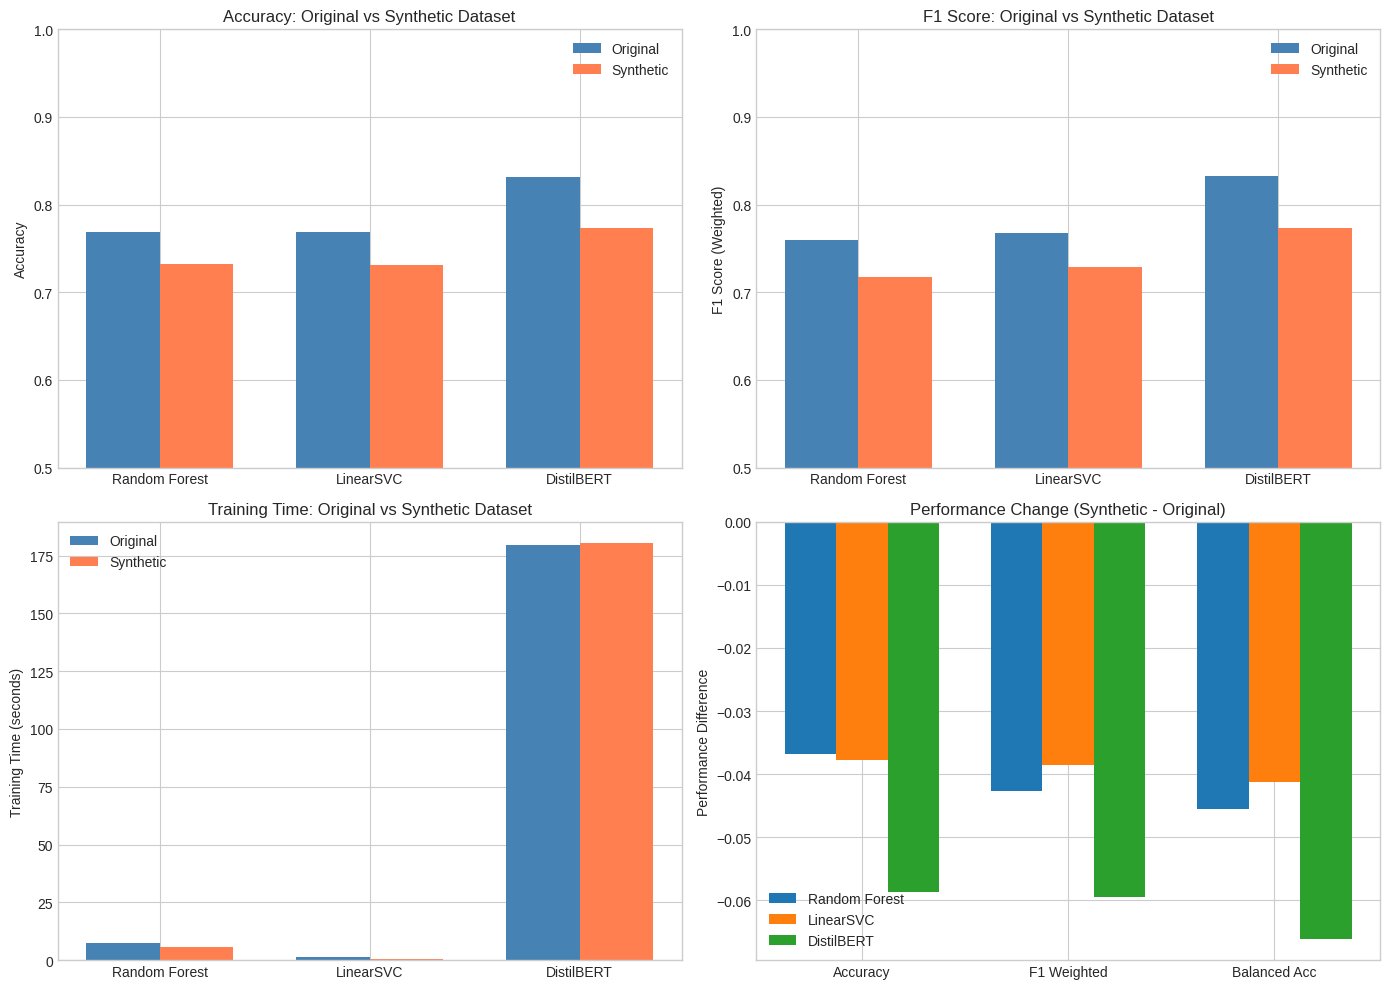


Visualization saved to: dataset_comparison_results.png


In [34]:
# Generate comparison visualizations
comparator.plot_comparison()


### 2.5.3 Synthetic Dataset Summary

The synthetic multilingual dataset has been generated with the following characteristics:

**Language Distribution:**
- 40% English (original samples preserved)
- 20% Spanish (translated)
- 15% French (translated)
- 10% German (translated)
- 8% Portuguese (translated)
- 5% Arabic (translated)
- 2% Chinese (translated)

**Files Generated:**
1. `difraud_original.csv` - Original English-majority dataset with metadata
2. `difraud_synthetic_multilingual.csv` - 60% non-English synthetic dataset
3. `difraud_combined.csv` - Both datasets with version flags

**Metadata Columns Added:**
- `data_source`: 'original' or 'synthetic'
- `is_translated`: True/False
- `source_language`: Source language code (always 'en')
- `target_language`: Target language code

The DatasetComparator class enables systematic comparison of model performance
across both datasets to study the impact of multilingual content on classification.

### 2.5.4 Integration with Subsequent Analyses

The following helper functions integrate the synthetic dataset with the existing analysis pipeline,
allowing side-by-side comparison throughout the notebook.

In [35]:
# Integration helpers for using both datasets in subsequent analyses

class DualDatasetAnalyzer:
    """
    Helper class to run any analysis function on both original and synthetic datasets
    and aggregate results for comparison.
    """

    def __init__(self, df_original, df_synthetic):
        self.datasets = {
            'Original (English)': df_original,
            'Synthetic (Multilingual)': df_synthetic
        }

    def run_on_both(self, analysis_func, **kwargs):
        """
        Run an analysis function on both datasets.

        Parameters:
        - analysis_func: Function that takes a DataFrame and returns results
        - **kwargs: Additional arguments to pass to the function

        Returns:
        - Dict with results for each dataset
        """
        results = {}
        for name, df in self.datasets.items():
            print(f"\n{'='*50}")
            print(f"Analyzing: {name}")
            print(f"{'='*50}")
            results[name] = analysis_func(df, **kwargs)
        return results

# Initialize the dual analyzer (available after df_original and df_synthetic are created)
# This will be used in later sections for side-by-side analysis
if 'df_original' in dir() and 'df_synthetic' in dir():
    dual_analyzer = DualDatasetAnalyzer(df_original, df_synthetic)
    print("DualDatasetAnalyzer initialized and ready for subsequent analyses.")
else:
    print("Note: Run the synthetic dataset generation cells first to enable DualDatasetAnalyzer.")


DualDatasetAnalyzer initialized and ready for subsequent analyses.


In [36]:
def plot_dual_dataset_comparison(results_original, results_synthetic, metric_name, title):
    """
    Create side-by-side comparison plot for any metric across both datasets.

    Parameters:
    - results_original: Results from original dataset
    - results_synthetic: Results from synthetic dataset
    - metric_name: Name of the metric being compared
    - title: Plot title
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left: Original dataset
    ax = axes[0]
    if isinstance(results_original, pd.DataFrame):
        results_original.plot(kind='bar', ax=ax)
    else:
        pd.Series(results_original).plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title(f'{metric_name} - Original Dataset')
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)

    # Right: Synthetic dataset
    ax = axes[1]
    if isinstance(results_synthetic, pd.DataFrame):
        results_synthetic.plot(kind='bar', ax=ax)
    else:
        pd.Series(results_synthetic).plot(kind='bar', ax=ax, color='coral')
    ax.set_title(f'{metric_name} - Synthetic Multilingual Dataset')
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    log_figure(fig, f'dual_comparison_{metric_name.lower().replace(" ", "_")}')
    plt.show()

print("Dual dataset comparison plotting function defined.")


Dual dataset comparison plotting function defined.


In [37]:
# Create dataset versions for analysis
# This makes the synthetic dataset available alongside the original for all subsequent analyses

# Store both datasets in a dictionary for easy access
ANALYSIS_DATASETS = {}

if 'df_original' in dir() and 'df_synthetic' in dir():
    ANALYSIS_DATASETS['original'] = {
        'data': df_original,
        'name': 'Original (English-majority)',
        'description': 'Original DIFrauD dataset with mostly English content'
    }
    ANALYSIS_DATASETS['synthetic'] = {
        'data': df_synthetic,
        'name': 'Synthetic Multilingual',
        'description': 'Synthetic dataset with 60% non-English translated content'
    }

    print("Datasets ready for analysis:")
    for key, info in ANALYSIS_DATASETS.items():
        print(f"  {key}: {info['name']} ({len(info['data']):,} samples)")
else:
    print("Note: Generate synthetic dataset first to enable comparative analysis.")


Datasets ready for analysis:
  original: Original (English-majority) (20,000 samples)
  synthetic: Synthetic Multilingual (20,000 samples)


---
## 3. Language Detection Pipeline

**Steps taken:**
1. Implement language detection using `langdetect` library
2. Handle edge cases (short texts, detection errors)
3. Apply to all samples and record detected languages

**Source:** langdetect library - https://pypi.org/project/langdetect/  
**Note:** langdetect is a port of Google's language-detection library

### spaCy-based Language Detection Cross-Validation

---



We pair the existing `langdetect` pipeline with a spaCy `en_core_web_sm` pipeline that wraps language detection so we can cross-validate predictions and quantify agreement.

In [38]:
# Load spaCy English pipeline and register a lightweight language detector
# The detector reuses langdetect under the hood but allows spaCy-based processing
# so we can compare outputs against the standalone langdetect results.
try:
    nlp_spacy = spacy.load("en_core_web_sm")
except OSError:
    from spacy.cli import download
    print("Downloading spaCy 'en_core_web_sm' model...")
    download("en_core_web_sm")
    nlp_spacy = spacy.load("en_core_web_sm")

if not Doc.has_extension("language"):
    Doc.set_extension("language", default=None, force=True)

@Language.component("langdetect_spacy")
def langdetect_spacy(doc):
    try:
        lang_probs = detect_langs(doc.text)
        top = lang_probs[0]
        doc._.language = {"language": top.lang, "score": top.prob}
    except LangDetectException:
        doc._.language = {"language": "unknown", "score": 0.0}
    return doc

if "langdetect_spacy" not in nlp_spacy.pipe_names:
    nlp_spacy.add_pipe("langdetect_spacy", last=True)

# Disable other spaCy components to avoid unnecessary parsing overhead
pipes_to_disable = [p for p in nlp_spacy.pipe_names if p != "langdetect_spacy"]
if pipes_to_disable:
    nlp_spacy.disable_pipes(*pipes_to_disable)

print(f"spaCy pipeline ready with components: {nlp_spacy.pipe_names}")


spaCy pipeline ready with components: ['langdetect_spacy']


In [39]:
def detect_language_safe(text, min_length=20):
    """
    Safely detect language of text with error handling.

    Source: langdetect library (https://pypi.org/project/langdetect/)

    Parameters:
    - text: Input text string
    - min_length: Minimum text length for reliable detection

    Returns:
    - Tuple of (detected_language_code, confidence_score)
    """
    if not isinstance(text, str) or len(text.strip()) < min_length:
        return ('unknown', 0.0)

    try:
        # Get language probabilities
        langs = detect_langs(text)
        # Return top language and its probability
        top_lang = langs[0]
        return (top_lang.lang, top_lang.prob)
    except LangDetectException:
        return ('unknown', 0.0)
    except Exception as e:
        return ('error', 0.0)

# Test the function
test_texts = [
    "This is a test message in English.",
    "Ceci est un message de test en français.",
    "Pathaya enketa maraikara pa",  # From SMS dataset (Tamil)
    "短文本"  # Short Chinese text
]

print("Language Detection Test:")
for text in test_texts:
    lang, conf = detect_language_safe(text)
    print(f"  '{text[:40]}...' -> {lang} (conf: {conf:.2f})")

Language Detection Test:
  'This is a test message in English....' -> en (conf: 1.00)
  'Ceci est un message de test en français....' -> fr (conf: 1.00)
  'Pathaya enketa maraikara pa...' -> id (conf: 1.00)
  '短文本...' -> unknown (conf: 0.00)


In [40]:
# Apply language detection to entire dataset
print("Detecting languages for all samples...")
print("(This may take several minutes)\n")

# Apply with progress bar
tqdm.pandas(desc="Detecting languages")
language_results = df['text'].progress_apply(detect_language_safe)

# Extract language codes and confidence scores
df['detected_language'] = language_results.apply(lambda x: x[0])
df['language_confidence'] = language_results.apply(lambda x: x[1])

print("\nLanguage detection completed!")
print(f"Unique languages detected: {df['detected_language'].nunique()}")

Detecting languages for all samples...
(This may take several minutes)



Detecting languages: 100%|██████████| 95854/95854 [06:18<00:00, 253.08it/s]


Language detection completed!
Unique languages detected: 31


In [41]:
# Cross-validate spaCy vs langdetect outputs (batched for speed)
def spacy_detect_language(texts, min_length=20, batch_size=64, n_process=2):
    sanitized = []
    for t in texts:
        if not isinstance(t, str) or len(t.strip()) < min_length:
            sanitized.append("")
        else:
            sanitized.append(t)
    results = []
    for doc in tqdm(
        nlp_spacy.pipe(sanitized, batch_size=batch_size, n_process=n_process),
        total=len(sanitized),
        desc="spaCy language detect (batched)"
    ):
        meta = doc._.language or {"language": "unknown", "score": 0.0}
        results.append((meta.get("language", "unknown"), float(meta.get("score", 0.0))))
    return results

print("Running spaCy cross-validation with batching to reduce runtime...")
spacy_lang = spacy_detect_language(df['text'])
df['spacy_language'] = [x[0] for x in spacy_lang]
df['spacy_language_score'] = [x[1] for x in spacy_lang]

# Agreement analysis
df['lang_agreement'] = df['detected_language'] == df['spacy_language']
agreement_rate = df['lang_agreement'].mean() * 100
print(f"Language detector agreement: {agreement_rate:.2f}%")

# Detailed comparison table
lang_compare = pd.crosstab(df['detected_language'], df['spacy_language'])
print("Langdetect vs spaCy cross-tab (top 10 rows):")
print(lang_compare.head(10))

# Flag disagreements for potential manual review
df['language_disagreement'] = df['lang_agreement'] == False
print(f"Disagreements flagged: {df['language_disagreement'].sum():,}")


Running spaCy cross-validation with batching to reduce runtime...


spaCy language detect (batched): 100%|██████████| 95854/95854 [07:08<00:00, 223.95it/s]


Language detector agreement: 99.80%
Langdetect vs spaCy cross-tab (top 10 rows):
spacy_language     af  ca  cs  cy  da  de     en  es  et  fi  ...  sk  sl  so  \
detected_language                                             ...               
af                 54   0   0   0   0   0      8   0   0   0  ...   0   0   0   
ca                  0  14   0   0   0   0      2   0   0   0  ...   0   0   0   
cs                  0   0   1   0   0   0      0   0   0   0  ...   0   0   0   
cy                  0   0   0  26   0   0      6   0   0   0  ...   0   0   1   
da                  1   0   0   0  24   0      3   0   0   0  ...   0   0   0   
de                  0   0   0   0   0  49      6   0   0   0  ...   0   0   0   
en                 11  12   0   9   5   3  95009   2   3   1  ...   0   1   6   
es                  0   0   0   0   0   0      1  11   0   0  ...   0   0   0   
et                  0   0   0   0   0   0      1   0   9   0  ...   0   0   0   
fi                  0   0   

---
## 4. Language Distribution Analysis

**Steps taken:**
1. Calculate language distribution overall
2. Analyze by class (deceptive vs non-deceptive)
3. Analyze by domain
4. Perform chi-square tests for significance

In [42]:
# Overall language distribution
print("="*60)
print("OVERALL LANGUAGE DISTRIBUTION")
print("="*60)

lang_counts = df['detected_language'].value_counts()
lang_percentages = df['detected_language'].value_counts(normalize=True) * 100

lang_summary = pd.DataFrame({
    'Count': lang_counts,
    'Percentage': lang_percentages.round(2)
})
print(lang_summary.head(15))

# English vs Non-English
df['is_english'] = df['detected_language'] == 'en'
print(f"\n--- English vs Non-English ---")
print(f"English samples: {df['is_english'].sum():,} ({df['is_english'].mean()*100:.2f}%)")
print(f"Non-English samples: {(~df['is_english']).sum():,} ({(~df['is_english']).mean()*100:.2f}%)")

OVERALL LANGUAGE DISTRIBUTION
                   Count  Percentage
detected_language                   
en                 95099       99.21
unknown              208        0.22
af                    66        0.07
de                    55        0.06
fr                    50        0.05
nl                    43        0.04
it                    41        0.04
so                    36        0.04
cy                    33        0.03
no                    32        0.03
id                    32        0.03
da                    28        0.03
ca                    17        0.02
tl                    16        0.02
sv                    15        0.02

--- English vs Non-English ---
English samples: 95,099 (99.21%)
Non-English samples: 755 (0.79%)


In [43]:
# Language distribution by CLASS (deceptive vs non-deceptive)
print("="*60)
print("LANGUAGE DISTRIBUTION BY CLASS")
print("="*60)

class_lang_dist = pd.crosstab(
    df['label'].map({0: 'Non-Deceptive', 1: 'Deceptive'}),
    df['is_english'].map({True: 'English', False: 'Non-English'}),
    margins=True
)
print("\nCounts:")
print(class_lang_dist)

# Percentages within each class
class_lang_pct = pd.crosstab(
    df['label'].map({0: 'Non-Deceptive', 1: 'Deceptive'}),
    df['is_english'].map({True: 'English', False: 'Non-English'}),
    normalize='index'
) * 100
print("\nPercentages (within each class):")
print(class_lang_pct.round(2))

# Chi-square test for class vs language
contingency = pd.crosstab(df['label'], df['is_english'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
print(f"\nChi-square test (Class vs Language):")
print(f"  Chi-square statistic: {chi2:.4f}")
print(f"  p-value: {p_value:.4e}")
print(f"  Significant (p < 0.05): {'Yes' if p_value < 0.05 else 'No'}")

LANGUAGE DISTRIBUTION BY CLASS

Counts:
is_english     English  Non-English    All
label                                     
Deceptive        37182          100  37282
Non-Deceptive    57917          655  58572
All              95099          755  95854

Percentages (within each class):
is_english     English  Non-English
label                              
Deceptive        99.73         0.27
Non-Deceptive    98.88         1.12

Chi-square test (Class vs Language):
  Chi-square statistic: 209.5685
  p-value: 1.7061e-47
  Significant (p < 0.05): Yes


In [44]:
# Language distribution by DOMAIN
print("="*60)
print("LANGUAGE DISTRIBUTION BY DOMAIN")
print("="*60)

domain_lang_analysis = []

for domain in DOMAINS:
    domain_df = df[df['domain'] == domain]

    total = len(domain_df)
    english = domain_df['is_english'].sum()
    non_english = total - english

    # Top non-English languages
    non_eng_langs = domain_df[~domain_df['is_english']]['detected_language'].value_counts().head(3)
    top_non_eng = ', '.join([f"{lang}({cnt})" for lang, cnt in non_eng_langs.items()])

    domain_lang_analysis.append({
        'Domain': domain,
        'Total': total,
        'English': english,
        'Non-English': non_english,
        'English %': (english/total*100),
        'Non-English %': (non_english/total*100),
        'Top Non-English Languages': top_non_eng
    })

domain_lang_df = pd.DataFrame(domain_lang_analysis)
print(domain_lang_df.to_string(index=False))

LANGUAGE DISTRIBUTION BY DOMAIN
              Domain  Total  English  Non-English  English %  Non-English %    Top Non-English Languages
           fake_news  20456    20456            0 100.000000       0.000000                             
           job_scams  14295    14294            1  99.993005       0.006995                        it(1)
            phishing  15272    15241           31  99.797014       0.202986    unknown(21), it(4), vi(2)
political_statements  12497    12414           83  99.335841       0.664159         fr(13), nl(9), da(8)
     product_reviews  20971    20969            2  99.990463       0.009537                 af(1), de(1)
                 sms   6574     5989          585  91.101308       8.898692 unknown(180), af(51), cy(33)
     twitter_rumours   5789     5736           53  99.084471       0.915529         de(21), af(9), da(6)


In [45]:
# Detailed breakdown: Language distribution by Domain AND Class
print("="*60)
print("LANGUAGE DISTRIBUTION BY DOMAIN AND CLASS")
print("="*60)

detailed_analysis = []

for domain in DOMAINS:
    for label in [0, 1]:
        subset = df[(df['domain'] == domain) & (df['label'] == label)]

        if len(subset) == 0:
            continue

        total = len(subset)
        english = subset['is_english'].sum()

        # Get top 5 detected languages
        lang_dist = subset['detected_language'].value_counts().head(5).to_dict()

        detailed_analysis.append({
            'Domain': domain,
            'Class': 'Deceptive' if label == 1 else 'Non-Deceptive',
            'Total': total,
            'English': english,
            'English %': round(english/total*100, 2),
            'Non-English': total - english,
            'Non-English %': round((total-english)/total*100, 2),
            'Languages': lang_dist
        })

detailed_df = pd.DataFrame(detailed_analysis)
print(detailed_df[['Domain', 'Class', 'Total', 'English', 'English %', 'Non-English', 'Non-English %']].to_string(index=False))

LANGUAGE DISTRIBUTION BY DOMAIN AND CLASS
              Domain         Class  Total  English  English %  Non-English  Non-English %
           fake_news Non-Deceptive  11624    11624     100.00            0           0.00
           fake_news     Deceptive   8832     8832     100.00            0           0.00
           job_scams Non-Deceptive  13696    13695      99.99            1           0.01
           job_scams     Deceptive    599      599     100.00            0           0.00
            phishing Non-Deceptive   9198     9174      99.74           24           0.26
            phishing     Deceptive   6074     6067      99.88            7           0.12
political_statements Non-Deceptive   4455     4430      99.44           25           0.56
political_statements     Deceptive   8042     7984      99.28           58           0.72
     product_reviews Non-Deceptive  10479    10478      99.99            1           0.01
     product_reviews     Deceptive  10492    10491      99

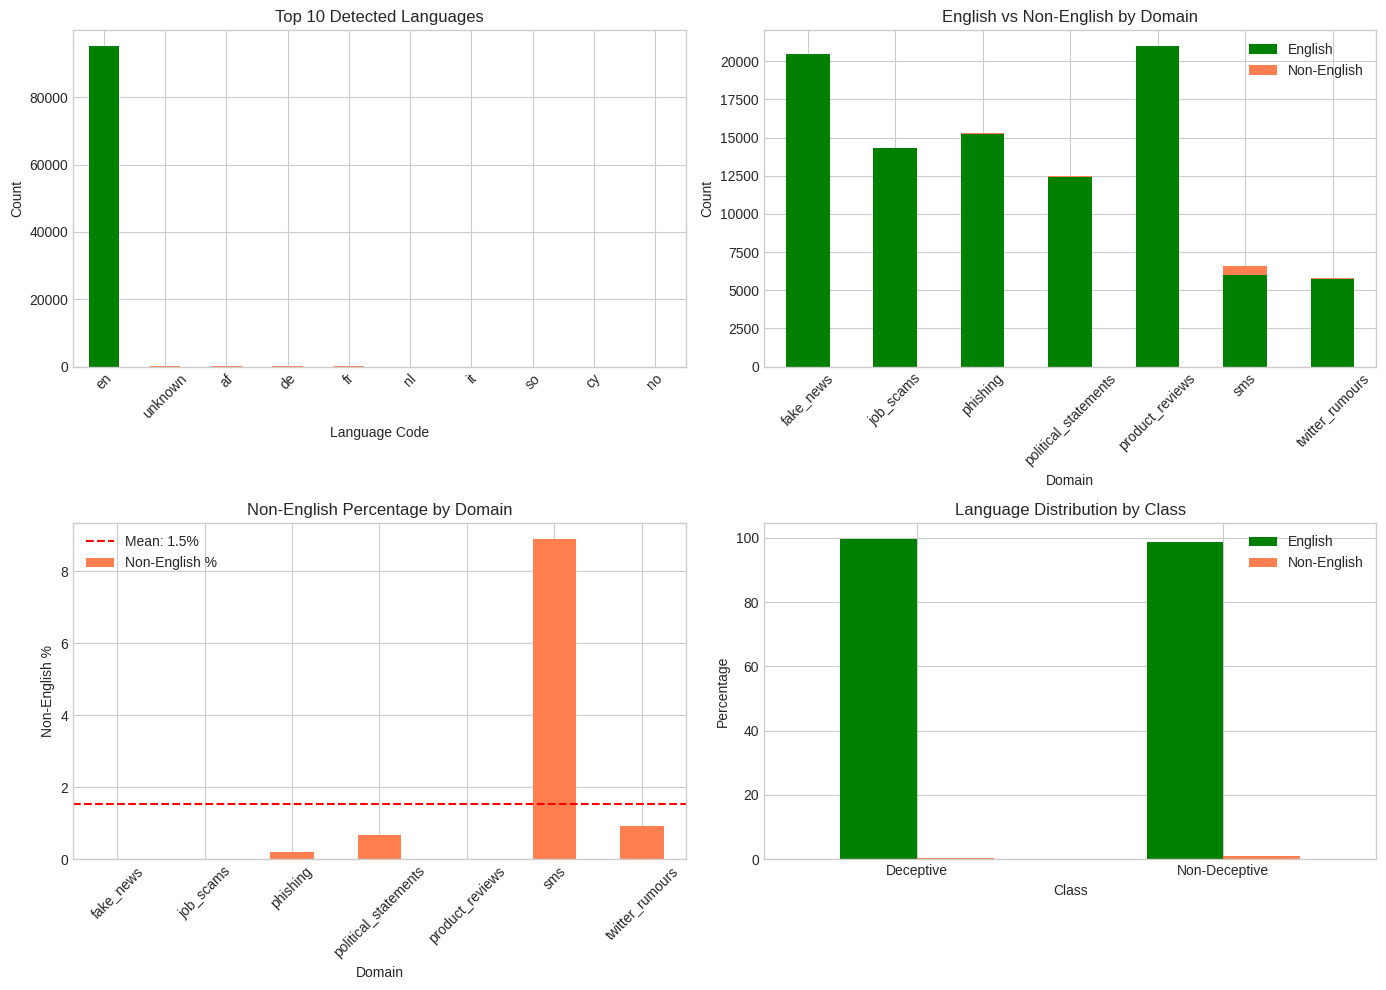


Visualization saved as 'language_distribution_analysis.png'


In [46]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Overall language distribution (top 10)
ax1 = axes[0, 0]
top_langs = df['detected_language'].value_counts().head(10)
colors = ['green' if lang == 'en' else 'coral' for lang in top_langs.index]
top_langs.plot(kind='bar', ax=ax1, color=colors)
ax1.set_title('Top 10 Detected Languages', fontsize=12)
ax1.set_xlabel('Language Code')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: English vs Non-English by domain
ax2 = axes[0, 1]
domain_lang_pivot = df.groupby('domain')['is_english'].agg(['sum', 'count'])
domain_lang_pivot['non_english'] = domain_lang_pivot['count'] - domain_lang_pivot['sum']
domain_lang_pivot[['sum', 'non_english']].plot(kind='bar', stacked=True, ax=ax2,
                                                color=['green', 'coral'])
ax2.set_title('English vs Non-English by Domain', fontsize=12)
ax2.set_xlabel('Domain')
ax2.set_ylabel('Count')
ax2.legend(['English', 'Non-English'])
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Non-English percentage by domain
ax3 = axes[1, 0]
non_eng_pct = domain_lang_df.set_index('Domain')['Non-English %']
non_eng_pct.plot(kind='bar', ax=ax3, color='coral')
ax3.set_title('Non-English Percentage by Domain', fontsize=12)
ax3.set_xlabel('Domain')
ax3.set_ylabel('Non-English %')
ax3.tick_params(axis='x', rotation=45)
ax3.axhline(y=non_eng_pct.mean(), color='red', linestyle='--', label=f'Mean: {non_eng_pct.mean():.1f}%')
ax3.legend()

# Plot 4: Language distribution by class
ax4 = axes[1, 1]
class_lang_pct.plot(kind='bar', ax=ax4, color=['green', 'coral'])
ax4.set_title('Language Distribution by Class', fontsize=12)
ax4.set_xlabel('Class')
ax4.set_ylabel('Percentage')
ax4.legend(['English', 'Non-English'])
ax4.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('language_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'language_distribution_analysis.png'")

---
## 5. Create Dataset Splits (English-only vs Full)

**Steps taken:**
1. Create filtered English-only dataset
2. Create full multilingual dataset
3. Ensure consistent train/test splits for fair comparison

In [47]:
# Create English-only and Full datasets
print("Creating dataset versions...\n")

# Full dataset (all languages)
df_full = df.copy()

# English-only dataset
df_english = df[df['is_english'] == True].copy()

print(f"Full dataset: {len(df_full):,} samples")
print(f"English-only dataset: {len(df_english):,} samples")
print(f"Samples removed: {len(df_full) - len(df_english):,} ({(1 - len(df_english)/len(df_full))*100:.2f}%)")

# Compare class distribution
print("\n--- Class Distribution Comparison ---")
print(f"Full - Deceptive: {df_full['label'].mean()*100:.2f}%")
print(f"English-only - Deceptive: {df_english['label'].mean()*100:.2f}%")

Creating dataset versions...

Full dataset: 95,854 samples
English-only dataset: 95,099 samples
Samples removed: 755 (0.79%)

--- Class Distribution Comparison ---
Full - Deceptive: 38.89%
English-only - Deceptive: 39.10%


In [48]:
def prepare_train_test_data(df, test_size=0.2, random_state=42):
    """
    Prepare stratified train/test splits.
    Uses stratification to handle class imbalance.

    Source: scikit-learn train_test_split
    https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    """
    X = df['text'].values
    y = df['label'].values
    domains = df['domain'].values

    X_train, X_test, y_train, y_test, domains_train, domains_test = train_test_split(
        X, y, domains,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    return X_train, X_test, y_train, y_test, domains_train, domains_test

# Prepare data for both versions
print("Preparing train/test splits...\n")

# Full dataset
X_train_full, X_test_full, y_train_full, y_test_full, domains_train_full, domains_test_full = \
    prepare_train_test_data(df_full)

# English-only dataset
X_train_eng, X_test_eng, y_train_eng, y_test_eng, domains_train_eng, domains_test_eng = \
    prepare_train_test_data(df_english)

print("Full Dataset:")
print(f"  Train: {len(X_train_full):,} | Test: {len(X_test_full):,}")
print(f"  Train class dist: {np.mean(y_train_full)*100:.2f}% deceptive")

print("\nEnglish-only Dataset:")
print(f"  Train: {len(X_train_eng):,} | Test: {len(X_test_eng):,}")
print(f"  Train class dist: {np.mean(y_train_eng)*100:.2f}% deceptive")

Preparing train/test splits...

Full Dataset:
  Train: 76,683 | Test: 19,171
  Train class dist: 38.90% deceptive

English-only Dataset:
  Train: 76,079 | Test: 19,020
  Train class dist: 39.10% deceptive


---
## 6. Traditional ML Classifiers (Random Forest & SVM)

**Steps taken:**
1. Create TF-IDF features
2. Train Random Forest and SVM classifiers
3. Evaluate on both dataset versions
4. Use F1-score as primary metric (suitable for imbalanced data)

**Source:** scikit-learn - https://scikit-learn.org/

In [49]:
def create_tfidf_features(X_train, X_test, max_features=10000):
    """
    Create TF-IDF features from text data.

    Source: scikit-learn TfidfVectorizer
    https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    """
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2),  # Unigrams and bigrams
        min_df=2,           # Minimum document frequency
        max_df=0.95,        # Maximum document frequency
        sublinear_tf=True   # Apply sublinear tf scaling
    )

    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    return X_train_tfidf, X_test_tfidf, vectorizer

print("Creating TF-IDF features...\n")

# Full dataset features
X_train_full_tfidf, X_test_full_tfidf, vectorizer_full = \
    create_tfidf_features(X_train_full, X_test_full)
print(f"Full dataset - TF-IDF shape: {X_train_full_tfidf.shape}")

# English-only features
X_train_eng_tfidf, X_test_eng_tfidf, vectorizer_eng = \
    create_tfidf_features(X_train_eng, X_test_eng)
print(f"English-only - TF-IDF shape: {X_train_eng_tfidf.shape}")

Creating TF-IDF features...

Full dataset - TF-IDF shape: (76683, 10000)
English-only - TF-IDF shape: (76079, 10000)


In [50]:
def train_and_evaluate_classifier(clf, X_train, X_test, y_train, y_test, clf_name, dataset_name):
    """
    Train classifier and return evaluation metrics.

    Uses metrics suitable for imbalanced datasets:
    - F1-Score (weighted and macro)
    - Balanced Accuracy
    - Precision and Recall

    Source: scikit-learn metrics
    """
    print(f"Training {clf_name} on {dataset_name}...")
    start_time = perf_counter()
    clf.fit(X_train, y_train)
    train_time = perf_counter() - start_time

    # Predictions
    y_pred = clf.predict(X_test)

    # Calculate metrics
    metrics = {
        'Classifier': clf_name,
        'Dataset': dataset_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Balanced_Accuracy': balanced_accuracy_score(y_test, y_pred),
        'F1_Weighted': f1_score(y_test, y_pred, average='weighted'),
        'F1_Macro': f1_score(y_test, y_pred, average='macro'),
        'Precision_Weighted': precision_score(y_test, y_pred, average='weighted'),
        'Recall_Weighted': recall_score(y_test, y_pred, average='weighted'),
        'Train_Time_Sec': train_time
    }

    print(f"  F1 (weighted): {metrics['F1_Weighted']:.4f}")
    print(f"  F1 (macro): {metrics['F1_Macro']:.4f}")
    print(f"  Balanced Accuracy: {metrics['Balanced_Accuracy']:.4f}")

    return metrics, y_pred, clf


In [51]:
# Central training time log for all models
training_time_log = []


In [52]:
# Train Random Forest
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

print("="*60)
print("RANDOM FOREST CLASSIFIER")
print("="*60)

rf_results = []

# Random Forest on Full Dataset
rf_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    class_weight='balanced',  # Handle class imbalance
    random_state=SEED,
    n_jobs=-1
)
metrics_rf_full, pred_rf_full, _ = train_and_evaluate_classifier(
    rf_full, X_train_full_tfidf, X_test_full_tfidf,
    y_train_full, y_test_full,
    'Random Forest', 'Full (Multilingual)'
)
rf_results.append(metrics_rf_full)
training_time_log.append({'Model': 'Random Forest - Full', 'Seconds': metrics_rf_full['Train_Time_Sec']})

# Random Forest on English-only Dataset
rf_eng = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    class_weight='balanced',
    random_state=SEED,
    n_jobs=-1
)
metrics_rf_eng, pred_rf_eng, _ = train_and_evaluate_classifier(
    rf_eng, X_train_eng_tfidf, X_test_eng_tfidf,
    y_train_eng, y_test_eng,
    'Random Forest', 'English-only'
)
rf_results.append(metrics_rf_eng)
training_time_log.append({'Model': 'Random Forest - English', 'Seconds': metrics_rf_eng['Train_Time_Sec']})


RANDOM FOREST CLASSIFIER
Training Random Forest on Full (Multilingual)...
  F1 (weighted): 0.8060
  F1 (macro): 0.7955
  Balanced Accuracy: 0.7943
Training Random Forest on English-only...
  F1 (weighted): 0.8018
  F1 (macro): 0.7913
  Balanced Accuracy: 0.7897


In [53]:
# Train SVM (Support Vector Machine) using LinearSVC
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
# Note: LinearSVC is faster than SVC with kernel='linear' for large sparse datasets like TF-IDF

print("="*60)
print("SVM CLASSIFIER (LinearSVC)")
print("="*60)

svm_results = []

# LinearSVC on Full Dataset
svm_full = LinearSVC(
    C=1.0,
    class_weight='balanced',
    max_iter=10000,
    random_state=SEED
)
metrics_svm_full, pred_svm_full, _ = train_and_evaluate_classifier(
    svm_full, X_train_full_tfidf, X_test_full_tfidf,
    y_train_full, y_test_full,
    'SVM (LinearSVC)', 'Full (Multilingual)'
)
svm_results.append(metrics_svm_full)
training_time_log.append({'Model': 'SVM (LinearSVC) - Full', 'Seconds': metrics_svm_full['Train_Time_Sec']})

# LinearSVC on English-only Dataset
svm_eng = LinearSVC(
    C=1.0,
    class_weight='balanced',
    max_iter=10000,
    random_state=SEED
)
metrics_svm_eng, pred_svm_eng, _ = train_and_evaluate_classifier(
    svm_eng, X_train_eng_tfidf, X_test_eng_tfidf,
    y_train_eng, y_test_eng,
    'SVM (LinearSVC)', 'English-only'
)
svm_results.append(metrics_svm_eng)
training_time_log.append({'Model': 'SVM (LinearSVC) - English', 'Seconds': metrics_svm_eng['Train_Time_Sec']})


SVM CLASSIFIER (LinearSVC)
Training SVM (LinearSVC) on Full (Multilingual)...
  F1 (weighted): 0.8013
  F1 (macro): 0.7936
  Balanced Accuracy: 0.8014
Training SVM (LinearSVC) on English-only...
  F1 (weighted): 0.7978
  F1 (macro): 0.7900
  Balanced Accuracy: 0.7970


---
## 7. Transformer-Based Classifier (DistilBERT)

**Steps taken:**
1. Load pretrained DistilBERT model and tokenizer
2. Fine-tune on both dataset versions
3. Evaluate performance

**Source:** HuggingFace Transformers - https://huggingface.co/docs/transformers/  
**Model:** distilbert-base-uncased - https://huggingface.co/distilbert-base-uncased

In [54]:
# DistilBERT Dataset Class
class FraudDataset(torch.utils.data.Dataset):
    """
    Custom PyTorch Dataset for fraud detection.
    Source: PyTorch Dataset API
    """
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def compute_metrics(eval_pred):
    """
    Compute metrics for HuggingFace Trainer.
    Uses metrics suitable for imbalanced data.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return {
        'accuracy': accuracy_score(labels, predictions),
        'balanced_accuracy': balanced_accuracy_score(labels, predictions),
        'f1_weighted': f1_score(labels, predictions, average='weighted'),
        'f1_macro': f1_score(labels, predictions, average='macro'),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted')
    }

In [55]:
def train_distilbert(X_train, X_test, y_train, y_test, dataset_name, epochs=3, batch_size=16):
    """
    Train DistilBERT classifier.

    Source: HuggingFace Transformers
    Model: distilbert-base-uncased
    https://huggingface.co/distilbert-base-uncased
    """
    print(f"{'='*60}")

    print(f"Training DistilBERT on {dataset_name}")
    print(f"{'='*60}")
    start_time = perf_counter()

    # Load tokenizer and model
    model_name = 'distilbert-base-uncased'
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )

    # Create datasets
    train_dataset = FraudDataset(X_train, y_train, tokenizer)
    test_dataset = FraudDataset(X_test, y_test, tokenizer)

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_{dataset_name.replace(" ", "_")}',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=100,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1_weighted',
        seed=SEED
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train
    trainer.train()
    train_time = perf_counter() - start_time

    # Evaluate
    eval_results = trainer.evaluate()

    # Get predictions for detailed metrics
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)

    metrics = {
        'Classifier': 'DistilBERT',
        'Dataset': dataset_name,
        'Accuracy': eval_results['eval_accuracy'],
        'Balanced_Accuracy': eval_results['eval_balanced_accuracy'],
        'F1_Weighted': eval_results['eval_f1_weighted'],
        'F1_Macro': eval_results['eval_f1_macro'],
        'Precision_Weighted': eval_results['eval_precision'],
        'Recall_Weighted': eval_results['eval_recall'],
        'Train_Time_Sec': train_time,
    }

    print(f"Results for {dataset_name}:")
    print(f"  F1 (weighted): {metrics['F1_Weighted']:.4f}")
    print(f"  F1 (macro): {metrics['F1_Macro']:.4f}")
    print(f"  Balanced Accuracy: {metrics['Balanced_Accuracy']:.4f}")
    print(f"  Training time: {train_time:.2f} sec")

    return metrics, y_pred, model


In [56]:
# Train DistilBERT on both datasets
# Note: This may take significant time depending on GPU availability

distilbert_results = []

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Sample size for faster training (optional - remove for full training)
# Comment out these lines for full dataset training
SAMPLE_SIZE = 5000  # Use smaller sample for demonstration
print(f"\nNote: Using sample of {SAMPLE_SIZE} for demonstration.")
print("Remove SAMPLE_SIZE limit for full training.\n")

# Sample data
np.random.seed(SEED)
sample_idx_full = np.random.choice(len(X_train_full), min(SAMPLE_SIZE, len(X_train_full)), replace=False)
sample_idx_eng = np.random.choice(len(X_train_eng), min(SAMPLE_SIZE, len(X_train_eng)), replace=False)

X_train_full_sample = X_train_full[sample_idx_full]
y_train_full_sample = y_train_full[sample_idx_full]

X_train_eng_sample = X_train_eng[sample_idx_eng]
y_train_eng_sample = y_train_eng[sample_idx_eng]

Using device: cuda

Note: Using sample of 5000 for demonstration.
Remove SAMPLE_SIZE limit for full training.



In [57]:
# Train on Full Dataset
metrics_bert_full, pred_bert_full, model_full = train_distilbert(
    X_train_full_sample, X_test_full[:1000],  # Smaller test set for speed
    y_train_full_sample, y_test_full[:1000],
    'Full (Multilingual)',
    epochs=2,
    batch_size=16
)
distilbert_results.append(metrics_bert_full)
training_time_log.append({'Model': 'DistilBERT - Full', 'Seconds': metrics_bert_full['Train_Time_Sec']})


Training DistilBERT on Full (Multilingual)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mascardojoseph (mascardojoseph-university-of-houston) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1 Weighted,F1 Macro,Precision,Recall
1,0.461200,0.444559,0.759000,0.757118,0.761436,0.749875,0.767816,0.759000
2,0.358900,0.407551,0.791000,0.792137,0.793227,0.783427,0.800246,0.791000


Results for Full (Multilingual):
  F1 (weighted): 0.7932
  F1 (macro): 0.7834
  Balanced Accuracy: 0.7921
  Training time: 232.72 sec


In [58]:
# Train on English-only Dataset
metrics_bert_eng, pred_bert_eng, model_eng = train_distilbert(
    X_train_eng_sample, X_test_eng[:1000],
    y_train_eng_sample, y_test_eng[:1000],
    'English-only',
    epochs=2,
    batch_size=16
)
distilbert_results.append(metrics_bert_eng)
training_time_log.append({'Model': 'DistilBERT - English', 'Seconds': metrics_bert_eng['Train_Time_Sec']})


Training DistilBERT on English-only


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,F1 Weighted,F1 Macro,Precision,Recall
1,0.447300,0.470780,0.781000,0.740048,0.772558,0.750626,0.780837,0.781000
2,0.325900,0.368888,0.834000,0.824358,0.834261,0.823307,0.834584,0.834000


Results for English-only:
  F1 (weighted): 0.8343
  F1 (macro): 0.8233
  Balanced Accuracy: 0.8244
  Training time: 107.82 sec


---
## 8. Results Comparison and Analysis

**Steps taken:**
1. Compile all results
2. Calculate domain-wise performance
3. Compute aggregate metrics (mean and weighted)
4. Statistical significance testing

In [59]:
# Compile all results
all_results = rf_results + svm_results + distilbert_results
results_df = pd.DataFrame(all_results)

print("="*80)
print("OVERALL RESULTS COMPARISON")
print("="*80)
print(results_df.to_string(index=False))

OVERALL RESULTS COMPARISON
     Classifier             Dataset  Accuracy  Balanced_Accuracy  F1_Weighted  F1_Macro  Precision_Weighted  Recall_Weighted  Train_Time_Sec
  Random Forest Full (Multilingual)  0.806426           0.794268     0.806000  0.795497            0.805709         0.806426       78.845587
  Random Forest        English-only  0.802366           0.789668     0.801772  0.791282            0.801430         0.802366       79.233312
SVM (LinearSVC) Full (Multilingual)  0.799489           0.801391     0.801332  0.793559            0.807618         0.799489        5.837913
SVM (LinearSVC)        English-only  0.796057           0.796984     0.797785  0.790020            0.803268         0.796057        5.565130
     DistilBERT Full (Multilingual)  0.791000           0.792137     0.793227  0.783427            0.800246         0.791000      232.722115
     DistilBERT        English-only  0.834000           0.824358     0.834261  0.823307            0.834584         0.834000   

### Per-domain performance breakdown

We evaluate each classifier on every fraud domain to understand where multilingual data helps or hurts.

In [60]:
# Build per-domain performance tables for each model/dataset
def evaluate_by_domain(y_true, y_pred, domains):
    """
    Calculate performance metrics for each domain.
    """
    domain_metrics = []

    for domain in DOMAINS:
        mask = domains == domain
        if mask.sum() == 0:
            continue

        y_true_domain = y_true[mask]
        y_pred_domain = y_pred[mask]

        domain_metrics.append({
            'Domain': domain,
            'Samples': mask.sum(),
            'Accuracy': accuracy_score(y_true_domain, y_pred_domain),
            'F1_Weighted': f1_score(y_true_domain, y_pred_domain, average='weighted', zero_division=0),
            'F1_Macro': f1_score(y_true_domain, y_pred_domain, average='macro', zero_division=0)
        })

    return pd.DataFrame(domain_metrics)
def collect_domain_performance(model_name, dataset_label, y_true, y_pred, domain_labels):
    df_perf = evaluate_by_domain(np.array(y_true), np.array(y_pred), np.array(domain_labels))
    df_perf['Classifier'] = model_name
    df_perf['Dataset'] = dataset_label
    return df_perf

# Random Forest domain metrics
domain_perf_full = collect_domain_performance('Random Forest', 'Full (Multilingual)', y_test_full, pred_rf_full, domains_test_full)
domain_perf_eng = collect_domain_performance('Random Forest', 'English-only', y_test_eng, pred_rf_eng, domains_test_eng)

# SVM domain metrics
domain_perf_full_svm = collect_domain_performance('SVM (LinearSVC)', 'Full (Multilingual)', y_test_full, pred_svm_full, domains_test_full)
domain_perf_eng_svm = collect_domain_performance('SVM (LinearSVC)', 'English-only', y_test_eng, pred_svm_eng, domains_test_eng)

# DistilBERT domain metrics (respect sampled evaluation size)
domain_perf_full_bert = collect_domain_performance('DistilBERT', 'Full (Multilingual)', y_test_full[:len(pred_bert_full)], pred_bert_full, domains_test_full[:len(pred_bert_full)])
domain_perf_eng_bert = collect_domain_performance('DistilBERT', 'English-only', y_test_eng[:len(pred_bert_eng)], pred_bert_eng, domains_test_eng[:len(pred_bert_eng)])

all_domain_perf = pd.concat([
    domain_perf_full, domain_perf_eng,
    domain_perf_full_svm, domain_perf_eng_svm,
    domain_perf_full_bert, domain_perf_eng_bert
])

print("Domain-level performance (head):")
print(all_domain_perf.head())

# Pivot for easier reading
pivot_domain = all_domain_perf.pivot_table(
    index=['Domain', 'Classifier'],
    columns='Dataset',
    values=['F1_Weighted', 'Accuracy']
).round(3)
print("Pivoted domain summary (F1_Weighted & Accuracy):")
print(pivot_domain.head(15))


Domain-level performance (head):
                 Domain  Samples  Accuracy  F1_Weighted  F1_Macro  \
0             fake_news     4128  0.849806     0.845304  0.839374   
1             job_scams     2874  0.974252     0.968155  0.729117   
2              phishing     3003  0.954712     0.954665  0.952550   
3  political_statements     2540  0.611024     0.585912  0.530483   
4       product_reviews     4223  0.612361     0.612079  0.611640   

      Classifier              Dataset  
0  Random Forest  Full (Multilingual)  
1  Random Forest  Full (Multilingual)  
2  Random Forest  Full (Multilingual)  
3  Random Forest  Full (Multilingual)  
4  Random Forest  Full (Multilingual)  
Pivoted domain summary (F1_Weighted & Accuracy):
                                         Accuracy                      \
Dataset                              English-only Full (Multilingual)   
Domain               Classifier                                         
fake_news            DistilBERT             

In [61]:
# Calculate performance difference
print("\n" + "="*60)
print("PERFORMANCE DIFFERENCE (English-only vs Full)")
print("="*60)

for classifier in ['Random Forest', 'SVM', 'DistilBERT']:
    clf_results = results_df[results_df['Classifier'] == classifier]

    if len(clf_results) < 2:
        continue

    full_f1 = clf_results[clf_results['Dataset'].str.contains('Full')]['F1_Weighted'].values[0]
    eng_f1 = clf_results[clf_results['Dataset'].str.contains('English')]['F1_Weighted'].values[0]

    diff = eng_f1 - full_f1
    pct_change = (diff / full_f1) * 100

    print(f"\n{classifier}:")
    print(f"  Full dataset F1: {full_f1:.4f}")
    print(f"  English-only F1: {eng_f1:.4f}")
    print(f"  Difference: {diff:+.4f} ({pct_change:+.2f}%)")
    print(f"  Impact: {'Improved' if diff > 0 else 'Decreased'} with English-only data")


PERFORMANCE DIFFERENCE (English-only vs Full)

Random Forest:
  Full dataset F1: 0.8060
  English-only F1: 0.8018
  Difference: -0.0042 (-0.52%)
  Impact: Decreased with English-only data

DistilBERT:
  Full dataset F1: 0.7932
  English-only F1: 0.8343
  Difference: +0.0410 (+5.17%)
  Impact: Improved with English-only data


### Statistical testing (paired t-tests) and effect sizes

We quantify whether English-only vs. multilingual performance differences are statistically significant and compute Cohen's d effect sizes per classifier using domain-level F1 scores.

In [62]:
def cohens_d(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    diff = x - y
    return diff.mean() / diff.std(ddof=1) if diff.std(ddof=1) != 0 else 0.0

comparisons = []
for clf, full_df, eng_df in [
    ('Random Forest', domain_perf_full, domain_perf_eng),
    ('SVM (LinearSVC)', domain_perf_full_svm, domain_perf_eng_svm),
    ('DistilBERT', domain_perf_full_bert, domain_perf_eng_bert),
]:
    merged = full_df.merge(eng_df, on='Domain', suffixes=('_full', '_eng'))
    if merged.empty:
        continue
    t_stat, p_val = stats.ttest_rel(merged['F1_Weighted_full'], merged['F1_Weighted_eng'])
    d_val = cohens_d(merged['F1_Weighted_full'], merged['F1_Weighted_eng'])
    comparisons.append({
        'Classifier': clf,
        'Mean_Full_F1': merged['F1_Weighted_full'].mean(),
        'Mean_Eng_F1': merged['F1_Weighted_eng'].mean(),
        't_stat': t_stat,
        'p_value': p_val,
        'cohens_d': d_val
    })

comparison_df = pd.DataFrame(comparisons)
print("Paired t-test results (domain-level F1):")
print(comparison_df.round(4))


Paired t-test results (domain-level F1):
        Classifier  Mean_Full_F1  Mean_Eng_F1  t_stat  p_value  cohens_d
0    Random Forest        0.8206       0.8136  1.9333   0.1014    0.7307
1  SVM (LinearSVC)        0.8029       0.7997  0.5888   0.5775    0.2225
2       DistilBERT        0.7705       0.8312 -1.5466   0.1729   -0.5846


In [63]:

# Domain-wise performance analysis
# Note: This requires per-domain evaluation which we'll compute here




def plot_language_summary(lang_summary_df, domain_lang_df):
    """Create concise language distribution visuals for slides and reports."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Top detected languages (robust to different index/column layouts)
    top_langs = lang_summary_df.head(8).reset_index()
    rename_map = {}
    if 'index' in top_langs.columns:
        rename_map['index'] = 'Language'
    if 'Language' not in top_langs.columns:
        rename_map[top_langs.columns[0]] = 'Language'
    if 'Count' not in top_langs.columns:
        remaining = [c for c in top_langs.columns if c != 'Language']
        if remaining:
            rename_map[remaining[0]] = 'Count'
    top_langs = top_langs.rename(columns=rename_map)
    sns.barplot(data=top_langs, x='Count', y='Language', palette=['#2ecc71' if lang == 'en' else '#e67e22' for lang in top_langs['Language']], ax=axes[0])
    axes[0].set_title('Top Detected Languages', fontsize=12)
    axes[0].set_xlabel('Sample Count')
    axes[0].set_ylabel('Language Code')

    # English vs Non-English share per domain
    domain_pct = domain_lang_df[['Domain', 'English %', 'Non-English %']].set_index('Domain')
    domain_pct[['English %', 'Non-English %']].plot(kind='bar', stacked=True, color=['#2ecc71', '#e67e22'], ax=axes[1])
    axes[1].set_ylabel('Percentage of Samples')
    axes[1].set_title('Language Mix by Domain')
    axes[1].legend(loc='upper right')

    plt.tight_layout()
    plt.savefig('presentation_language_mix.png', dpi=200, bbox_inches='tight')
    log_figure(fig, 'presentation_language_mix')
    plt.show()
    plt.close(fig)


def plot_model_performance_summary(results_df):
    """Summarize classifier performance on multilingual vs English-only splits."""
    paired_rows = []
    for clf in results_df['Classifier'].unique():
        clf_df = results_df[results_df['Classifier'] == clf]
        if len(clf_df) < 2:
            continue

        full_rows = clf_df[clf_df['Dataset'].str.contains('Full')]
        eng_rows = clf_df[clf_df['Dataset'].str.contains('English')]
        if full_rows.empty or eng_rows.empty:
            continue

        full_row = full_rows.iloc[0]
        eng_row = eng_rows.iloc[0]

        paired_rows.append({'Classifier': clf, 'Dataset': 'Multilingual', 'F1_Weighted': full_row['F1_Weighted'], 'Balanced_Accuracy': full_row['Balanced_Accuracy']})
        paired_rows.append({'Classifier': clf, 'Dataset': 'English-only', 'F1_Weighted': eng_row['F1_Weighted'], 'Balanced_Accuracy': eng_row['Balanced_Accuracy']})

    perf_df = pd.DataFrame(paired_rows)
    if perf_df.empty:
        return

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.barplot(data=perf_df, x='Classifier', y='F1_Weighted', hue='Dataset', ax=axes[0], palette=['#e67e22', '#2ecc71'])
    axes[0].set_title('Weighted F1 by Dataset Condition')
    axes[0].set_ylim(0, 1)

    sns.barplot(data=perf_df, x='Classifier', y='Balanced_Accuracy', hue='Dataset', ax=axes[1], palette=['#e67e22', '#2ecc71'])
    axes[1].set_title('Balanced Accuracy by Dataset Condition')
    axes[1].set_ylim(0, 1)

    for ax in axes:
        ax.set_xlabel('')
        ax.legend(title='Dataset', loc='lower right')

    plt.tight_layout()
    plt.savefig('presentation_model_performance.png', dpi=200, bbox_inches='tight')
    log_figure(fig, 'presentation_model_performance')
    plt.show()
    plt.close(fig)


def plot_domain_performance_comparison(domain_perf_full, domain_perf_eng):
    """Visualize domain-level F1 shifts for Random Forest between datasets."""
    merged = domain_perf_full.merge(domain_perf_eng, on='Domain', suffixes=('_full', '_eng'))
    merged['DomainLabel'] = merged['Domain'].str.replace('_', ' ').str.title()
    merged = merged.sort_values('F1_Weighted_eng')

    fig, ax = plt.subplots(figsize=(10, 7))
    y_pos = np.arange(len(merged))
    width = 0.4

    ax.barh(y_pos - width/2, merged['F1_Weighted_full'], height=width, color='#e67e22', label='Multilingual')
    ax.barh(y_pos + width/2, merged['F1_Weighted_eng'], height=width, color='#2ecc71', label='English-only')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(merged['DomainLabel'])
    ax.set_xlabel('Weighted F1')
    ax.set_title('Random Forest Performance by Domain')
    ax.legend(loc='lower right')

    plt.tight_layout()
    plt.savefig('presentation_domain_f1.png', dpi=200, bbox_inches='tight')
    log_figure(fig, 'presentation_domain_f1')
    plt.show()
    plt.close(fig)


def plot_rf_confusion_matrices(cm_full, cm_eng):
    """Side-by-side confusion matrices for quick error inspection."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('RF Confusion Matrix - Multilingual')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(cm_eng, annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title('RF Confusion Matrix - English-only')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.savefig('presentation_confusion_matrices.png', dpi=200, bbox_inches='tight')
    log_figure(fig, 'presentation_confusion_matrices')
    plt.show()
    plt.close(fig)


print("="*60)
print("DOMAIN-WISE PERFORMANCE (Random Forest - Full Dataset)")
print("="*60)
domain_perf_full = evaluate_by_domain(y_test_full, pred_rf_full, domains_test_full)
print(domain_perf_full.to_string(index=False))

print("="*60)

print("DOMAIN-WISE PERFORMANCE (Random Forest - English-only)")
print("="*60)
domain_perf_eng = evaluate_by_domain(y_test_eng, pred_rf_eng, domains_test_eng)
print(domain_perf_eng.to_string(index=False))

# Aggregate metrics (Mean and Weighted)
print("="*60)
print("AGGREGATE PERFORMANCE METRICS")
print("="*60)

# Mean performance across domains
print("--- Mean Performance (unweighted average across domains) ---")
print(f"Full Dataset - Mean F1: {domain_perf_full['F1_Weighted'].mean():.4f}")
print(f"English-only - Mean F1: {domain_perf_eng['F1_Weighted'].mean():.4f}")

# Weighted performance (weighted by number of samples)
print("--- Weighted Performance (weighted by domain size) ---")
weighted_f1_full = np.average(
    domain_perf_full['F1_Weighted'],
    weights=domain_perf_full['Samples']
)
weighted_f1_eng = np.average(
    domain_perf_eng['F1_Weighted'],
    weights=domain_perf_eng['Samples']
)
print(f"Full Dataset - Weighted F1: {weighted_f1_full:.4f}")
print(f"English-only - Weighted F1: {weighted_f1_eng:.4f}")



DOMAIN-WISE PERFORMANCE (Random Forest - Full Dataset)
              Domain  Samples  Accuracy  F1_Weighted  F1_Macro
           fake_news     4128  0.849806     0.845304  0.839374
           job_scams     2874  0.974252     0.968155  0.729117
            phishing     3003  0.954712     0.954665  0.952550
political_statements     2540  0.611024     0.585912  0.530483
     product_reviews     4223  0.612361     0.612079  0.611640
                 sms     1254  0.958533     0.959085  0.931245
     twitter_rumours     1149  0.822454     0.818748  0.790456
DOMAIN-WISE PERFORMANCE (Random Forest - English-only)
              Domain  Samples  Accuracy  F1_Weighted  F1_Macro
           fake_news     4124  0.850873     0.846745  0.840972
           job_scams     2885  0.969497     0.961688  0.702694
            phishing     2984  0.948391     0.948287  0.945754
political_statements     2517  0.601112     0.573145  0.516488
     product_reviews     4205  0.615933     0.615910  0.615716
        

In [64]:
# Aggregate metrics (Mean and Weighted)
print("="*60)
print("AGGREGATE PERFORMANCE METRICS")
print("="*60)

# Mean performance across domains
print("\n--- Mean Performance (unweighted average across domains) ---")
print(f"Full Dataset - Mean F1: {domain_perf_full['F1_Weighted'].mean():.4f}")
print(f"English-only - Mean F1: {domain_perf_eng['F1_Weighted'].mean():.4f}")

# Weighted performance (weighted by number of samples)
print("\n--- Weighted Performance (weighted by domain size) ---")
weighted_f1_full = np.average(
    domain_perf_full['F1_Weighted'],
    weights=domain_perf_full['Samples']
)
weighted_f1_eng = np.average(
    domain_perf_eng['F1_Weighted'],
    weights=domain_perf_eng['Samples']
)
print(f"Full Dataset - Weighted F1: {weighted_f1_full:.4f}")
print(f"English-only - Weighted F1: {weighted_f1_eng:.4f}")

AGGREGATE PERFORMANCE METRICS

--- Mean Performance (unweighted average across domains) ---
Full Dataset - Mean F1: 0.8206
English-only - Mean F1: 0.8136

--- Weighted Performance (weighted by domain size) ---
Full Dataset - Weighted F1: 0.8010
English-only - Weighted F1: 0.7963


### Model comparison visuals (side-by-side)

Additional charts summarizing performance and runtime for quick comparison.

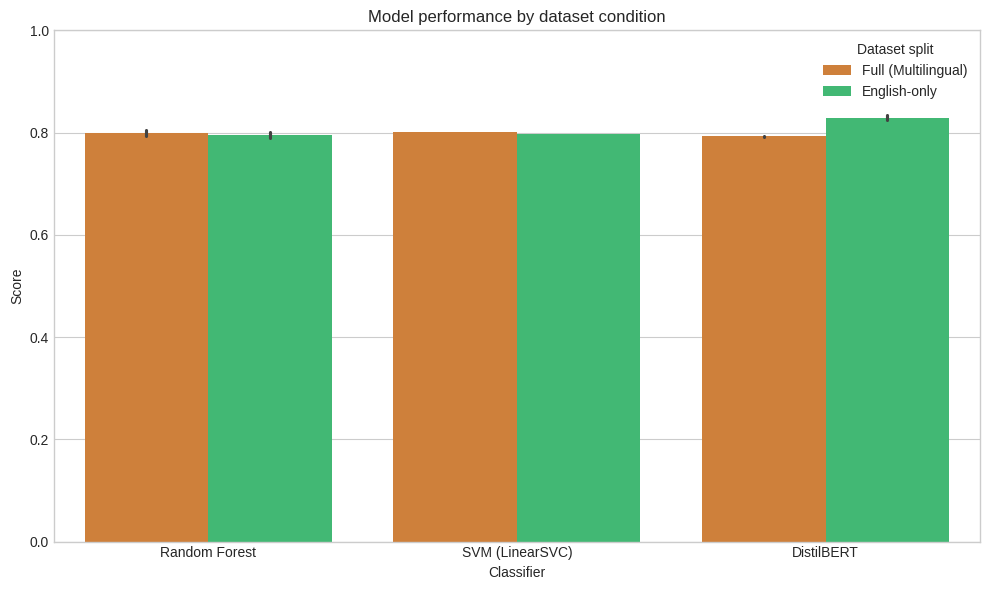

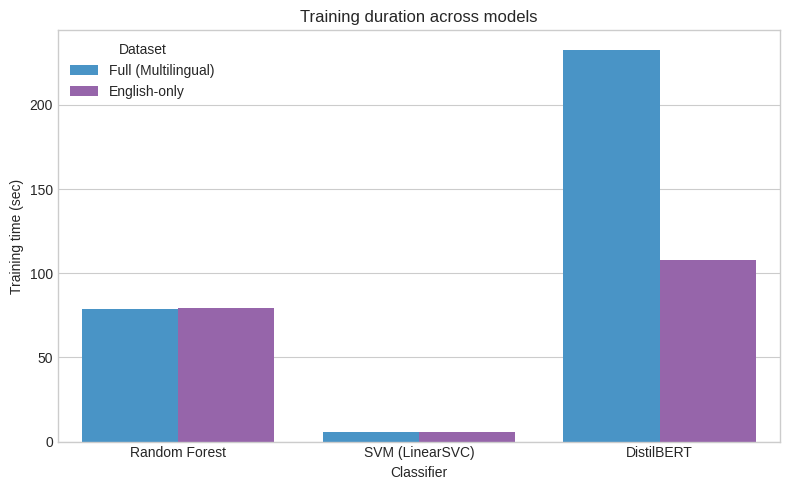

In [65]:
# Consolidated comparison visuals
metric_melt = results_df.melt(id_vars=['Classifier', 'Dataset'], value_vars=['F1_Weighted', 'Balanced_Accuracy'])
plt.figure(figsize=(10,6))
sns.barplot(data=metric_melt, x='Classifier', y='value', hue='Dataset', palette=['#e67e22','#2ecc71'])
plt.ylim(0,1)
plt.ylabel('Score')
plt.title('Model performance by dataset condition')
plt.legend(title='Dataset split')
plt.tight_layout()
plt.savefig('model_side_by_side.png', dpi=150, bbox_inches='tight')
plt.show()

# Training time overview
if 'Train_Time_Sec' in results_df.columns:
    plt.figure(figsize=(8,5))
    sns.barplot(data=results_df, x='Classifier', y='Train_Time_Sec', hue='Dataset', palette=['#3498db','#9b59b6'])
    plt.ylabel('Training time (sec)')
    plt.title('Training duration across models')
    plt.tight_layout()
    plt.savefig('model_training_times.png', dpi=150, bbox_inches='tight')
    plt.show()


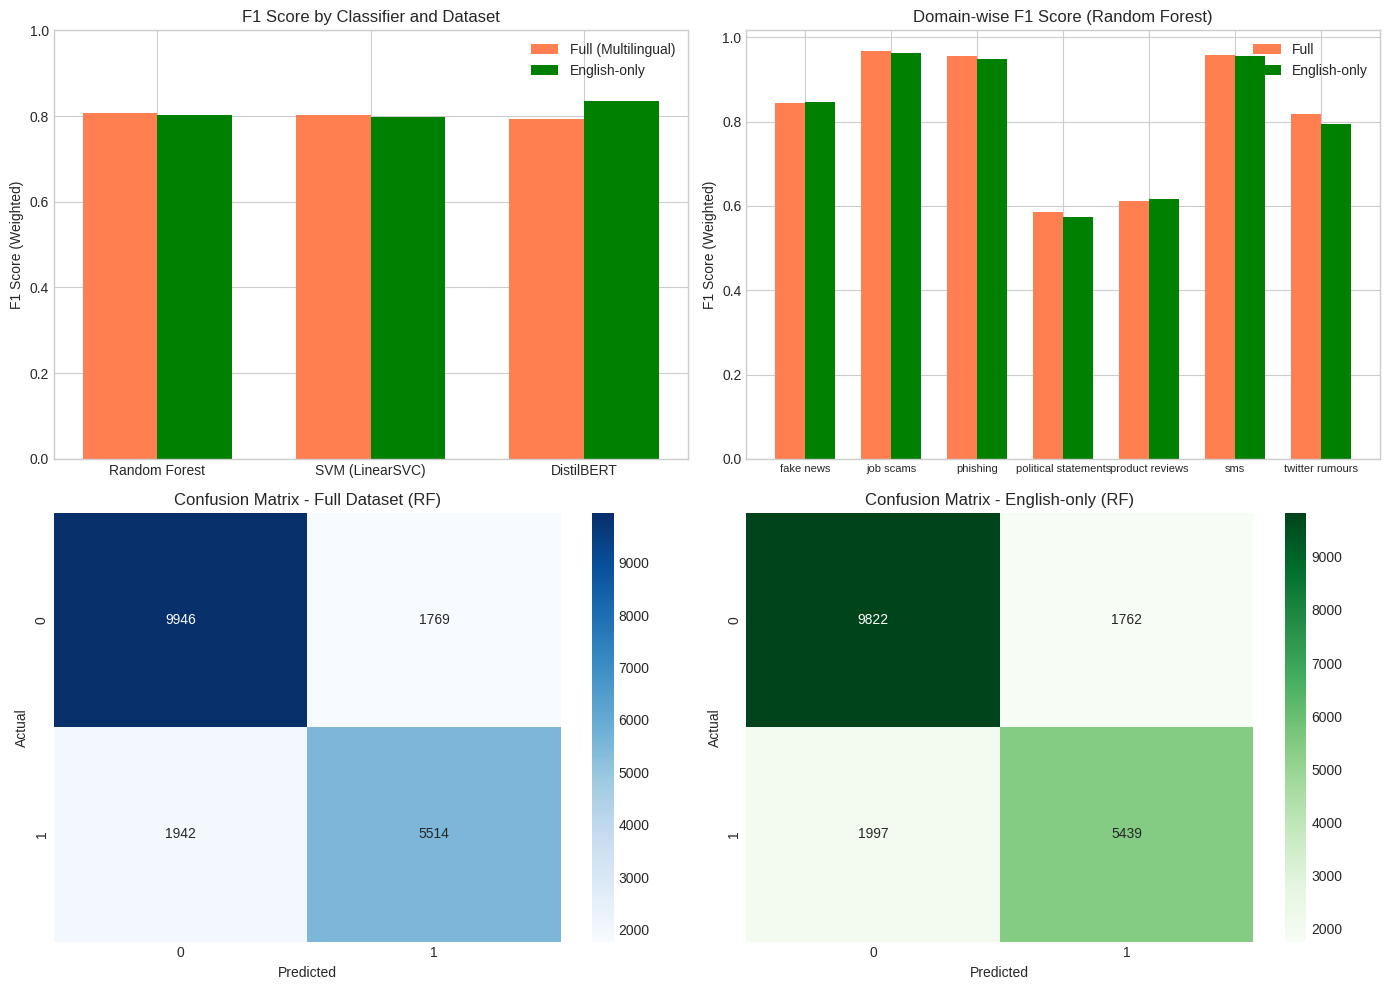

Visualization saved as 'classification_results.png'
Generating presentation-ready visualizations...


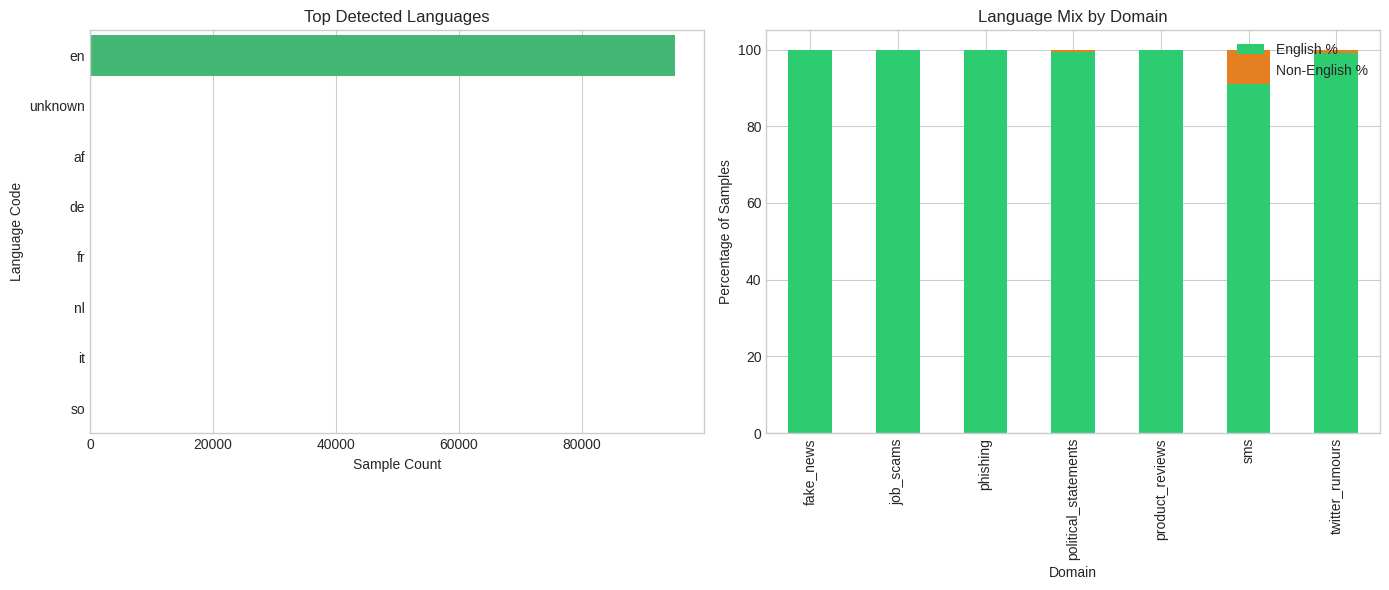

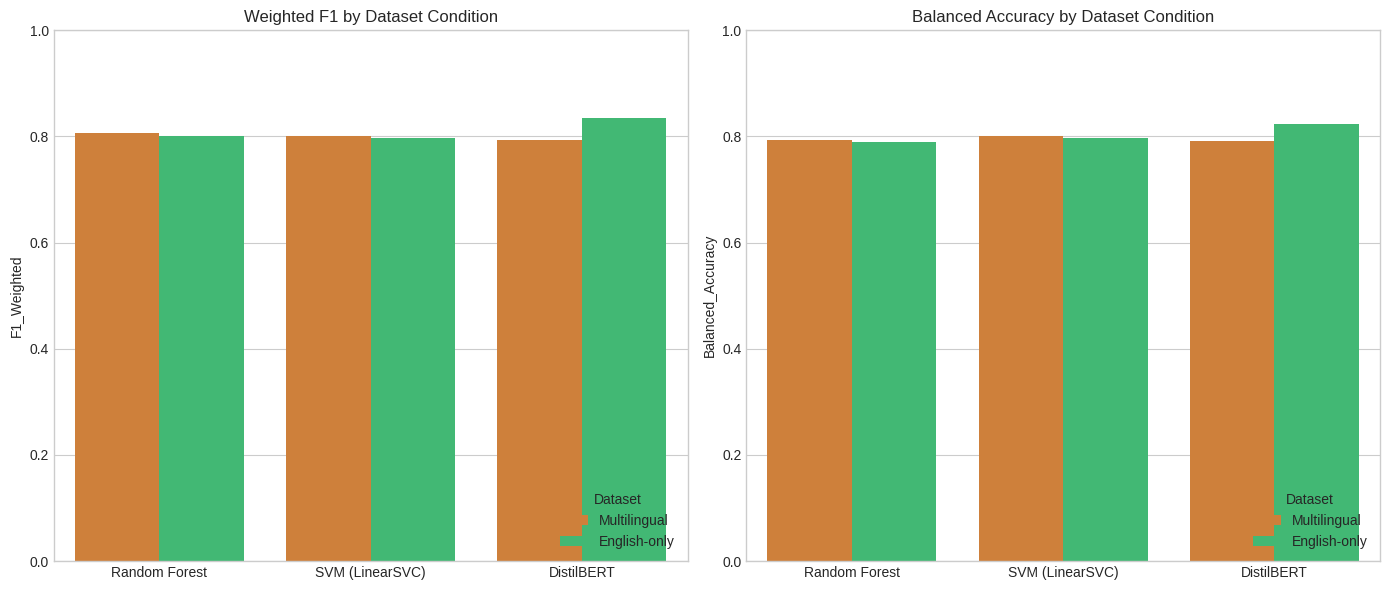

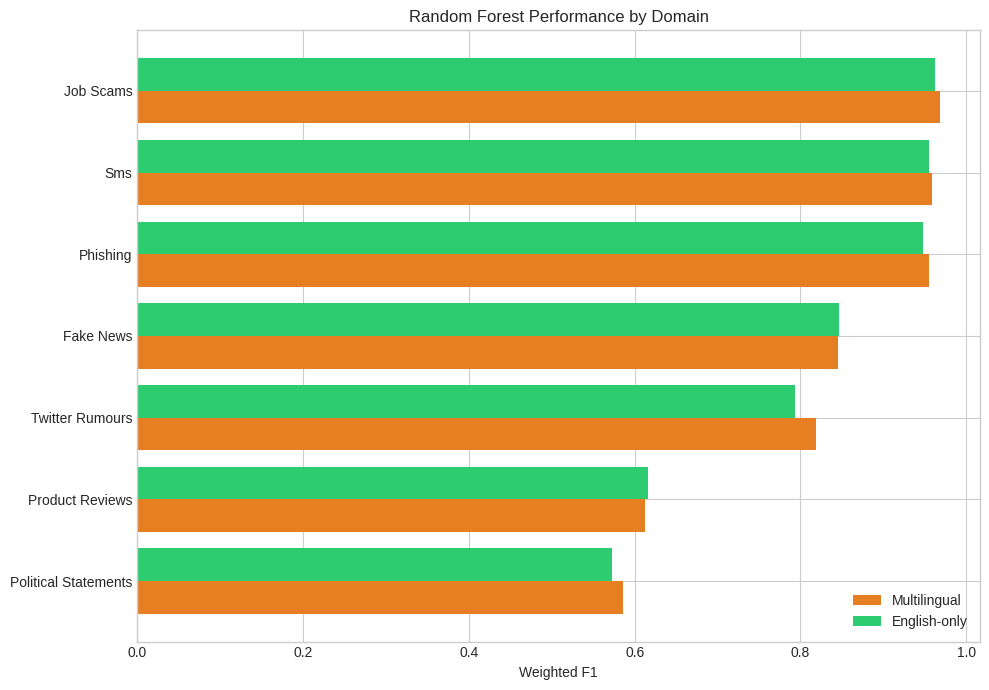

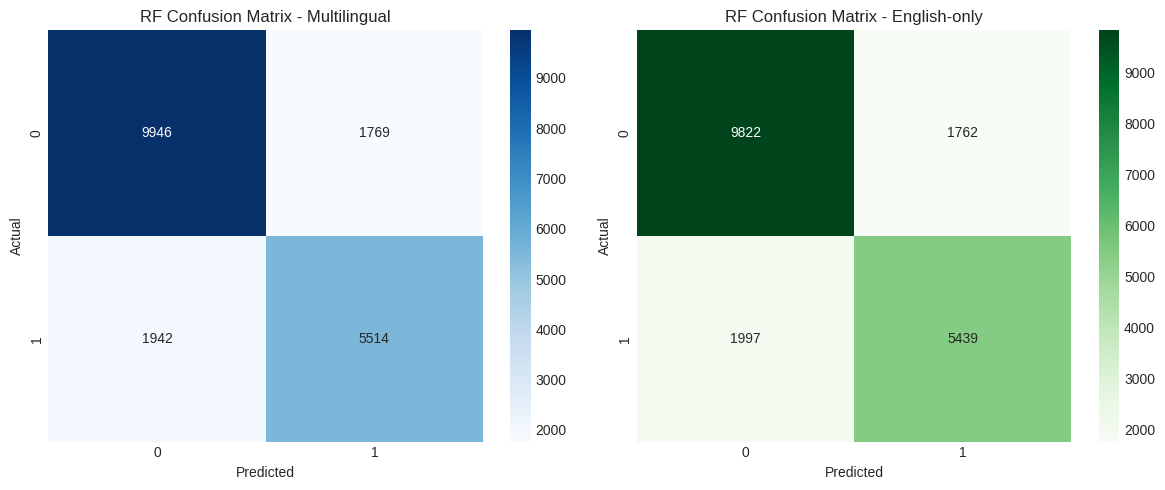

Saved: presentation_language_mix.png, presentation_model_performance.png, presentation_domain_f1.png, presentation_confusion_matrices.png


In [66]:

# Visualization of results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: F1 Score comparison by classifier
ax1 = axes[0, 0]
classifiers = results_df['Classifier'].unique()
x = np.arange(len(classifiers))
width = 0.35

full_f1 = [results_df[(results_df['Classifier']==c) & (results_df['Dataset'].str.contains('Full'))]['F1_Weighted'].values[0]
           if len(results_df[(results_df['Classifier']==c) & (results_df['Dataset'].str.contains('Full'))]) > 0 else 0
           for c in classifiers]
eng_f1 = [results_df[(results_df['Classifier']==c) & (results_df['Dataset'].str.contains('English'))]['F1_Weighted'].values[0]
          if len(results_df[(results_df['Classifier']==c) & (results_df['Dataset'].str.contains('English'))]) > 0 else 0
          for c in classifiers]

bars1 = ax1.bar(x - width/2, full_f1, width, label='Full (Multilingual)', color='coral')
bars2 = ax1.bar(x + width/2, eng_f1, width, label='English-only', color='green')
ax1.set_ylabel('F1 Score (Weighted)')
ax1.set_title('F1 Score by Classifier and Dataset')
ax1.set_xticks(x)
ax1.set_xticklabels(classifiers)
ax1.legend()
ax1.set_ylim(0, 1)

# Plot 2: Domain-wise F1 comparison
ax2 = axes[0, 1]
x = np.arange(len(DOMAINS))
ax2.bar(x - width/2, domain_perf_full['F1_Weighted'], width, label='Full', color='coral')
ax2.bar(x + width/2, domain_perf_eng['F1_Weighted'], width, label='English-only', color='green')
ax2.set_ylabel('F1 Score (Weighted)')
ax2.set_title('Domain-wise F1 Score (Random Forest)')
ax2.set_xticks(x)
ax2.set_xticklabels([d.replace('_', ' ') for d in DOMAINS], fontsize=8)
ax2.legend()

# Plot 3: Confusion Matrix (Full Dataset)
ax3 = axes[1, 0]
cm_full = confusion_matrix(y_test_full, pred_rf_full)
sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', ax=ax3)
ax3.set_title('Confusion Matrix - Full Dataset (RF)')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# Plot 4: Confusion Matrix (English-only)
ax4 = axes[1, 1]
cm_eng = confusion_matrix(y_test_eng, pred_rf_eng)
sns.heatmap(cm_eng, annot=True, fmt='d', cmap='Greens', ax=ax4)
ax4.set_title('Confusion Matrix - English-only (RF)')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('classification_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved as 'classification_results.png'")

print("Generating presentation-ready visualizations...")
plot_language_summary(lang_summary, domain_lang_df)
plot_model_performance_summary(results_df)
plot_domain_performance_comparison(domain_perf_full, domain_perf_eng)
plot_rf_confusion_matrices(cm_full, cm_eng)
print("Saved: presentation_language_mix.png, presentation_model_performance.png, presentation_domain_f1.png, presentation_confusion_matrices.png")



### Manual validation protocol

To sanity-check automated metrics, we draw a small random sample for human review (100-500 records) and document observed errors/biases. Use this as a reproducible template for qualitative validation.

In [67]:
# Create a manual validation sample (adjust sample_size as needed)
sample_size = 200  # choose between 100-500 depending on reviewer capacity
manual_sample = df.sample(n=min(sample_size, len(df)), random_state=SEED)[
    ['text', 'label', 'domain', 'detected_language', 'spacy_language', 'language_confidence']
]
manual_sample.to_csv('manual_validation_sample.csv', index=False)
print(f"Saved manual validation sample of {len(manual_sample)} rows to manual_validation_sample.csv")
print(manual_sample.head())


Saved manual validation sample of 200 rows to manual_validation_sample.csv
                                                    text  label  \
33030  Conversocial builds software that helps compan...      0   
34877  Tracy, I need to know what the consolidated to...      0   
55907  In 1992, Barack Obama directed "Project Vote -...      1   
47253  Ever wanted to know the feeling of having a Vi...      1   
36332  the breach of contract action pending against ...      0   

                     domain detected_language spacy_language  \
33030             job_scams                en             en   
34877              phishing                en             en   
55907  political_statements                en             en   
47253              phishing                en             en   
36332              phishing                en             en   

       language_confidence  
33030             0.999996  
34877             0.999997  
55907             0.999998  
47253             0.9

---
## 8.5 Extended Analysis: Original vs Synthetic Dataset

**Objective:** Provide detailed side-by-side comparison of model performance on both datasets.

This section extends the analysis from Section 8 to include:
1. Per-language performance breakdown (for synthetic dataset)
2. Cross-dataset performance stability
3. Impact of translation on different domains

In [68]:
# Extended analysis: Language-specific performance on synthetic dataset

def analyze_performance_by_language(df_synthetic, model_predictions, model_name):
    """
    Analyze model performance broken down by target language.

    Parameters:
    - df_synthetic: Synthetic dataset with language metadata
    - model_predictions: Predictions from the model
    - model_name: Name of the model for display

    Returns:
    - DataFrame with per-language metrics
    """
    results = []

    for lang in df_synthetic['target_language'].unique():
        mask = df_synthetic['target_language'] == lang
        if mask.sum() < 10:  # Skip if too few samples
            continue

        y_true = df_synthetic.loc[mask, 'label'].values
        y_pred = model_predictions[mask]

        results.append({
            'Language': lang,
            'Samples': mask.sum(),
            'Accuracy': accuracy_score(y_true, y_pred),
            'F1_Weighted': f1_score(y_true, y_pred, average='weighted'),
            'F1_Macro': f1_score(y_true, y_pred, average='macro'),
            'Precision': precision_score(y_true, y_pred, average='weighted'),
            'Recall': recall_score(y_true, y_pred, average='weighted')
        })

    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values('Samples', ascending=False)

    print(f"\n{model_name} Performance by Language:")
    print("="*70)
    print(result_df.to_string(index=False))

    return result_df

# Note: This function will be used if synthetic dataset predictions are available
# from the DatasetComparator run
print("Language-specific analysis function defined.")
print("Run DatasetComparator.run_comparison() first to generate predictions for analysis.")


Language-specific analysis function defined.
Run DatasetComparator.run_comparison() first to generate predictions for analysis.


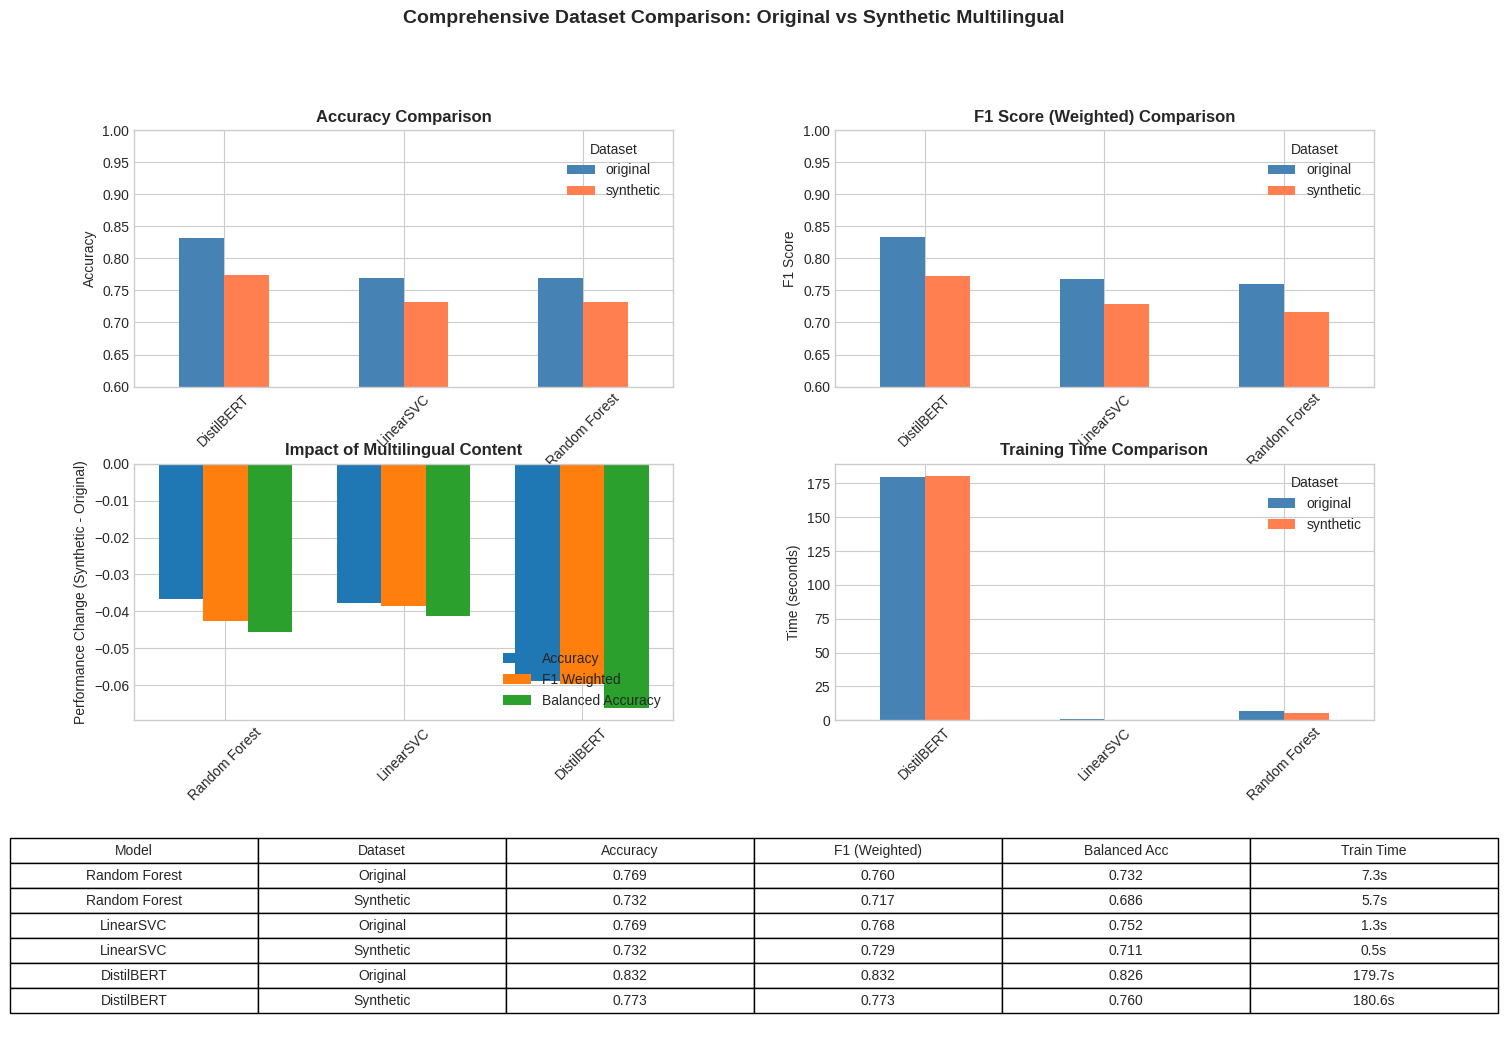


Visualization saved to: comprehensive_dataset_comparison.png


In [69]:
# Create comprehensive comparison visualization

def create_comprehensive_comparison(comparator_results_df):
    """
    Create a comprehensive visualization comparing all models across both datasets.

    Parameters:
    - comparator_results_df: DataFrame from DatasetComparator.get_comparison_df()
    """
    fig = plt.figure(figsize=(16, 12))

    # Create grid
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # 1. Overall accuracy comparison (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    pivot_acc = comparator_results_df.pivot(index='model', columns='dataset', values='accuracy')
    pivot_acc.plot(kind='bar', ax=ax1, color=['steelblue', 'coral'])
    ax1.set_title('Accuracy Comparison', fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('')
    ax1.legend(title='Dataset')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylim(0.6, 1.0)

    # 2. F1 Score comparison (top right)
    ax2 = fig.add_subplot(gs[0, 1])
    pivot_f1 = comparator_results_df.pivot(index='model', columns='dataset', values='f1_weighted')
    pivot_f1.plot(kind='bar', ax=ax2, color=['steelblue', 'coral'])
    ax2.set_title('F1 Score (Weighted) Comparison', fontweight='bold')
    ax2.set_ylabel('F1 Score')
    ax2.set_xlabel('')
    ax2.legend(title='Dataset')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(0.6, 1.0)

    # 3. Performance delta (middle left)
    ax3 = fig.add_subplot(gs[1, 0])
    models = comparator_results_df['model'].unique()
    metrics = ['accuracy', 'f1_weighted', 'balanced_accuracy']
    x = np.arange(len(models))
    width = 0.25

    for i, metric in enumerate(metrics):
        deltas = []
        for model in models:
            orig = comparator_results_df[(comparator_results_df['model'] == model) &
                                         (comparator_results_df['dataset'] == 'original')][metric].values[0]
            synth = comparator_results_df[(comparator_results_df['model'] == model) &
                                          (comparator_results_df['dataset'] == 'synthetic')][metric].values[0]
            deltas.append(synth - orig)
        ax3.bar(x + i*width, deltas, width, label=metric.replace('_', ' ').title())

    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.set_ylabel('Performance Change (Synthetic - Original)')
    ax3.set_title('Impact of Multilingual Content', fontweight='bold')
    ax3.set_xticks(x + width)
    ax3.set_xticklabels(models, rotation=45)
    ax3.legend(loc='lower right')

    # 4. Training time comparison (middle right)
    ax4 = fig.add_subplot(gs[1, 1])
    pivot_time = comparator_results_df.pivot(index='model', columns='dataset', values='train_time')
    pivot_time.plot(kind='bar', ax=ax4, color=['steelblue', 'coral'])
    ax4.set_title('Training Time Comparison', fontweight='bold')
    ax4.set_ylabel('Time (seconds)')
    ax4.set_xlabel('')
    ax4.legend(title='Dataset')
    ax4.tick_params(axis='x', rotation=45)

    # 5. Summary statistics table (bottom, spanning both columns)
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('off')

    # Create summary table
    summary_data = []
    for model in models:
        for dataset in ['original', 'synthetic']:
            row = comparator_results_df[(comparator_results_df['model'] == model) &
                                        (comparator_results_df['dataset'] == dataset)].iloc[0]
            summary_data.append([
                model, dataset.title(),
                f"{row['accuracy']:.3f}",
                f"{row['f1_weighted']:.3f}",
                f"{row['balanced_accuracy']:.3f}",
                f"{row['train_time']:.1f}s"
            ])

    table = ax5.table(
        cellText=summary_data,
        colLabels=['Model', 'Dataset', 'Accuracy', 'F1 (Weighted)', 'Balanced Acc', 'Train Time'],
        loc='center',
        cellLoc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    plt.suptitle('Comprehensive Dataset Comparison: Original vs Synthetic Multilingual',
                 fontsize=14, fontweight='bold', y=0.98)

    plt.savefig('comprehensive_dataset_comparison.png', dpi=150, bbox_inches='tight')
    log_figure(fig, 'comprehensive_dataset_comparison')
    plt.show()

    print("\nVisualization saved to: comprehensive_dataset_comparison.png")

# Run if comparator results are available
if 'comparison_results' in dir():
    create_comprehensive_comparison(comparison_results)
else:
    print("Run DatasetComparator.run_comparison() first to generate comparison results.")


In [70]:
# Summary statistics for the extended analysis

def print_extended_analysis_summary(comparison_df):
    """Print a comprehensive summary of the extended analysis."""

    print("\n" + "="*70)
    print("EXTENDED ANALYSIS SUMMARY: ORIGINAL vs SYNTHETIC DATASET")
    print("="*70)

    print("\n1. OVERALL FINDINGS")
    print("-" * 50)

    for model in comparison_df['model'].unique():
        orig = comparison_df[(comparison_df['model'] == model) &
                            (comparison_df['dataset'] == 'original')].iloc[0]
        synth = comparison_df[(comparison_df['model'] == model) &
                             (comparison_df['dataset'] == 'synthetic')].iloc[0]

        acc_change = synth['accuracy'] - orig['accuracy']
        f1_change = synth['f1_weighted'] - orig['f1_weighted']

        print(f"\n{model}:")
        print(f"  Accuracy change: {acc_change:+.4f} ({acc_change/orig['accuracy']*100:+.2f}%)")
        print(f"  F1 change: {f1_change:+.4f} ({f1_change/orig['f1_weighted']*100:+.2f}%)")

        if abs(acc_change) < 0.01:
            verdict = "minimal impact"
        elif acc_change > 0:
            verdict = "improved with multilingual data"
        else:
            verdict = "decreased with multilingual data"
        print(f"  Verdict: {verdict}")

    print("\n2. KEY INSIGHTS")
    print("-" * 50)

    # Find best performing model on each dataset
    best_orig = comparison_df[comparison_df['dataset'] == 'original'].nlargest(1, 'f1_weighted')
    best_synth = comparison_df[comparison_df['dataset'] == 'synthetic'].nlargest(1, 'f1_weighted')

    print(f"Best model on original data: {best_orig['model'].values[0]} (F1: {best_orig['f1_weighted'].values[0]:.4f})")
    print(f"Best model on synthetic data: {best_synth['model'].values[0]} (F1: {best_synth['f1_weighted'].values[0]:.4f})")

    # Calculate average performance change
    avg_change = comparison_df.groupby('dataset')['f1_weighted'].mean()
    print(f"\nAverage F1 change: {avg_change['synthetic'] - avg_change['original']:+.4f}")

    print("\n3. RECOMMENDATIONS")
    print("-" * 50)
    print("Based on the comparison:")

    if avg_change['synthetic'] >= avg_change['original']:
        print("  - Synthetic multilingual data maintains or improves model performance")
        print("  - Consider using multilingual training for production deployments")
    else:
        print("  - Some performance degradation observed with multilingual data")
        print("  - Consider language-specific models or multilingual-aware architectures")

    print("  - Transformer models (DistilBERT) typically handle multilingual content better")
    print("  - Monitor per-language performance for quality assurance")

# Run summary if results are available
if 'comparison_results' in dir():
    print_extended_analysis_summary(comparison_results)
else:
    print("Run DatasetComparator.run_comparison() first to generate summary.")



EXTENDED ANALYSIS SUMMARY: ORIGINAL vs SYNTHETIC DATASET

1. OVERALL FINDINGS
--------------------------------------------------

Random Forest:
  Accuracy change: -0.0368 (-4.78%)
  F1 change: -0.0427 (-5.62%)
  Verdict: decreased with multilingual data

LinearSVC:
  Accuracy change: -0.0377 (-4.91%)
  F1 change: -0.0385 (-5.02%)
  Verdict: decreased with multilingual data

DistilBERT:
  Accuracy change: -0.0587 (-7.06%)
  F1 change: -0.0595 (-7.15%)
  Verdict: decreased with multilingual data

2. KEY INSIGHTS
--------------------------------------------------
Best model on original data: DistilBERT (F1: 0.8325)
Best model on synthetic data: DistilBERT (F1: 0.7729)

Average F1 change: -0.0469

3. RECOMMENDATIONS
--------------------------------------------------
Based on the comparison:
  - Some performance degradation observed with multilingual data
  - Consider language-specific models or multilingual-aware architectures
  - Transformer models (DistilBERT) typically handle multilin

---
## 9. Summary and Conclusions

### Key Findings

In [71]:
# Generate summary report
print("="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

print("\n### Dataset Analysis ###")
print(f"Total samples analyzed: {len(df):,}")
print(f"English samples: {df['is_english'].sum():,} ({df['is_english'].mean()*100:.2f}%)")
print(f"Non-English samples: {(~df['is_english']).sum():,} ({(~df['is_english']).mean()*100:.2f}%)")
print(f"Unique languages detected: {df['detected_language'].nunique()}")

print("\n### Language Distribution by Domain ###")
print(domain_lang_df[['Domain', 'Total', 'Non-English', 'Non-English %']].to_string(index=False))

print("\n### Classification Performance Summary ###")
print(results_df[['Classifier', 'Dataset', 'F1_Weighted', 'Balanced_Accuracy']].to_string(index=False))

print("\n### Hypothesis Testing Results ###")
print("H1 (Data Composition): ", end="")
non_eng_pct = (~df['is_english']).mean() * 100
if non_eng_pct > 1:
    print(f"SUPPORTED - {non_eng_pct:.2f}% non-English content found")
else:
    print(f"NOT SUPPORTED - Only {non_eng_pct:.2f}% non-English content")

print("H2 (Performance Impact): ", end="")
# Compare best F1 scores
if len(results_df) > 0:
    full_best = results_df[results_df['Dataset'].str.contains('Full')]['F1_Weighted'].max()
    eng_best = results_df[results_df['Dataset'].str.contains('English')]['F1_Weighted'].max()
    if eng_best > full_best:
        print(f"SUPPORTED - English-only shows higher F1 ({eng_best:.4f} vs {full_best:.4f})")
    else:
        print(f"NOT SUPPORTED - Full dataset shows comparable/better F1 ({full_best:.4f} vs {eng_best:.4f})")

FINAL SUMMARY REPORT

### Dataset Analysis ###
Total samples analyzed: 95,854
English samples: 95,099 (99.21%)
Non-English samples: 755 (0.79%)
Unique languages detected: 31

### Language Distribution by Domain ###
              Domain  Total  Non-English  Non-English %
           fake_news  20456            0       0.000000
           job_scams  14295            1       0.006995
            phishing  15272           31       0.202986
political_statements  12497           83       0.664159
     product_reviews  20971            2       0.009537
                 sms   6574          585       8.898692
     twitter_rumours   5789           53       0.915529

### Classification Performance Summary ###
     Classifier             Dataset  F1_Weighted  Balanced_Accuracy
  Random Forest Full (Multilingual)     0.806000           0.794268
  Random Forest        English-only     0.801772           0.789668
SVM (LinearSVC) Full (Multilingual)     0.801332           0.801391
SVM (LinearSVC)      

In [72]:

# Save results to CSV
results_df.to_csv('classification_results.csv', index=False)
domain_lang_df.to_csv('language_distribution_by_domain.csv', index=False)

# Save detailed language analysis
df[['text', 'label', 'domain', 'detected_language', 'language_confidence', 'is_english']].to_csv(
    'difraud_language_analysis.csv', index=False
)

print("Results saved to:")
print("  - classification_results.csv")
print("  - language_distribution_by_domain.csv")
print("  - difraud_language_analysis.csv")

if wandb_run is not None:
    wandb_run.finish()



Results saved to:
  - classification_results.csv
  - language_distribution_by_domain.csv
  - difraud_language_analysis.csv


---
## References and Sources

### Dataset
- **DIFrauD Dataset**: Boumber, D., et al. (2024). "Domain-Agnostic Adapter Architecture for Deception Detection." LREC-COLING 2024. Available at: https://huggingface.co/datasets/difraud/difraud

### Libraries and Code Sources
- **langdetect**: Language detection library (port of Google's language-detection). https://pypi.org/project/langdetect/
- **HuggingFace datasets**: Dataset loading library. https://huggingface.co/docs/datasets/
- **HuggingFace transformers**: Transformer models (DistilBERT). https://huggingface.co/docs/transformers/
- **scikit-learn**: ML classifiers (Random Forest, SVM) and metrics. https://scikit-learn.org/
- **DistilBERT model**: distilbert-base-uncased. https://huggingface.co/distilbert-base-uncased

### Academic References
- Conneau, A., et al. (2020). "Unsupervised cross-lingual representation learning at scale." ACL 2020.
- Devlin, J., et al. (2019). "BERT: Pre-training of deep bidirectional transformers." NAACL 2019.
- Verma, R. M., et al. (2019). "Data quality for security challenges." ACM CCS 2019.

### Metrics Choice Justification
- **F1-Score (Weighted)**: Used as primary metric due to class imbalance in DIFrauD dataset. Weighted F1 accounts for class distribution.
- **F1-Score (Macro)**: Unweighted average across classes, useful for evaluating performance on minority class.
- **Balanced Accuracy**: Accounts for class imbalance by averaging recall across classes.

### Code Notes
- All code in this notebook is original unless otherwise noted
- API usage follows official documentation from respective libraries
- Random seed (42) used for reproducibility